# Анализ продаж компьютерных игр для компании "Стримчик"

## Введение

К нам на руки попала интересная задача - необходимо помочь маркетинговому отделу с расстановкой приоритетов по продвижению компьютерных игр. 

Формализованно задача звучит следующим образом: необходимо найти закономерности в данных, которые позволят понять, какие компьютерные игры и на какие платформы стоит ориентироваться в следующем, 2017 году, для достижения компанией большей прибыли.

Раскроем для себя эту задачу немного подробнее. По большому счету, для успешного решения задачи нам необходимо ответить на несколько вопросов:


1. *Какие платформы за актуальный промежуток времени наиболее популярны?*
2. *Какие факторы влияют на продажи игр?*
3. *Как отличаются друг от друга покупатели из разных регионов?*


Не ответив на первый вопрос, мы подставим наших коллег: сложно представить себе ситуацию хуже, чем когда ты рекламируешь продукт, который заведомо не имеет смысла покупать. Второй вопрос позволит нам понять, зависит ли количество продаж от качества продукции? Третий вопрос конкретизирует предпочтения покупателей из различных регионов; универсальная рекламная компания может провалиться в отдельных регионах, где платформа или жанр игры непопулярны.

Ответив на эти вопросы, мы сможем помочь нашим коллегам совершить построить более успешную стратегию на следующий год.

Также коллеги оставили нам 2 гипотезы на проверку, чем мы займёмся после основного исследования. 

Не будем тянуть, приступим!

## Импорт библиотек, написание фунций, обзор данных

### Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats as st
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

### Полезные функции

In [2]:
def brief(data, head=5):
    '''Функция быстрого просмотра датафрейма
    '''
    data.info()
    display(data.head(head))
    print('Количество дубликатов - {}'.format(data.duplicated().sum()))
    
def correct_data(data, form = "%Y-%m-%d"):
    '''Функция по корректировке даты
    
       Переводит даты,представленные в датасетах, в формат datetime'''
    data = pd.to_datetime(data, format= form)
    return data

def count_group(data, by, column):
    '''Группируем по количеству значений
    
    Позволяет сразу получить сгруппированный датафрейм, который можно присоединять без лишних проблем!'''
    return data.groupby(data[by]).count()[column].reset_index(drop=False)

def draw_hist(df_hist,title, xlabel, ylabel="Объем, ед."
                 , h_range=None, size=(10,7), bins=10, dpi=160, color = 'green'):
    '''Печатает красивую гистограмму.
    
    Позволяет сократить объемы текста, выводя красивую гистограмму одной строчкой'''
    plt.figure(figsize=size, dpi=dpi)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.hist(df_hist,bins=bins, range=h_range, color=color)
    plt.show()
    plt.close()
    
    
def draw_plot(plot_x, plot_y,title, xlabel, ylabel, size=(8,5), dpi=160, color = 'green'):
    '''Печатает красивый график.
    
    Позволяет сократить объемы текста, выводя красивый график одной строчкой'''
    plt.figure(figsize=size, dpi=dpi)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.plot(plot_x, plot_y, color=color)
    plt.show()
    plt.close()    
    
def draw_hist_comp(df_hist1, df_hist2,title, xlabel, lim_smart, lim_ultra, ylabel="Объем, ед."
                 , h_range=None, size=(8,5), bins=10, dpi=160):
    '''Печатает красивую гистограмму.
    
    Позволяет сократить объемы текста, выводя красивую гистограмму одной строчкой'''
    plt.figure(figsize=size, dpi=dpi)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.hist(df_hist1,bins=bins, range=h_range, color='green', label='Smart')
    plt.axvline(x=lim_smart, ymin=0, ymax=1000, label="Лимит по тарифу Smart", color='blue')
    plt.hist(df_hist2,bins=bins, range=h_range, color='orange', label='Ultra')
    plt.axvline(x=lim_ultra, ymin=0, ymax=1000, label="Лимит по тарифу Ultra", color='black')
    plt.legend()
    plt.show()
    plt.close()  
    

def value_from_dict(row,dictionary, att_search, att_key, att_negative=0):
    if np.isnan(row[att_search]):
        if row[att_key] in dictionary:
            return dictionary[row[att_key]]
        else:
            return att_negative
    else:
        return row[att_search]
    

def search_in_dict(df, dictionary, att_search, att_key, att_negative=0):
    return df.apply(value_from_dict, args=(dictionary, att_search, att_key, att_negative), axis=1)

### Получение датафрейма, поверхностное ознакомление с данными 

Ознакомимся с имеющейся информацией по продажам.

In [3]:
df = pd.read_csv("/datasets/games.csv")

In [4]:
brief(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Количество дубликатов - 0


Отметим для себя следующее: 

В большинстве случаев пропуски касаются только оценок пользователей, критиков и рейтинга, а это чувствительные данные. С ними надо разобраться - либо восстановить (придумав способ), либо отбросить. 
300 пропусков с годом выпуска необходимо просмотреть, может с ними что-то получится сделать.

Дубликатов пока нет, но посмотрим одну интересную вещь. Уверен, что мы встретим одну и ту же игру, которая выходит на разных платформах.

In [5]:
print("Количество уникальных значений для столбца Name: {}".format(df.groupby('Name')['Platform'].nunique()
                                                                   .sort_values(ascending=False)))

Количество уникальных значений для столбца Name: Name
Need for Speed: Most Wanted      10
FIFA 14                           9
Madden NFL 07                     9
Ratatouille                       9
LEGO Marvel Super Heroes          9
                                 ..
Paws & Claws: Pet Vet 2           1
Paws & Claws: Pampered Pets 2     1
Paws & Claws: Pampered Pets       1
Paws & Claws: Marine Rescue       1
 Beyblade Burst                   1
Name: Platform, Length: 11559, dtype: int64


In [6]:
display(df[df['Name'] == 'Need for Speed: Most Wanted'])

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


С данной проверкой мы попали в точку. Из среза данных по игре видим 2 периода - середина нулевых и начало 10-ых. Это объясняется очень легко - издатель серии назвал игру 2012 года также, как игру 2005. Это было сделано для того, чтобы привлечь большее число потенциальных покупателей, игравших в успешную игру от 2005 года. 

На моей практике (так как я играю в компьютерные игры довольно давно, уже 16 лет), такая ситуация, когда игры имеют одинаковое название, но различаются очень сильно по дате выпуска, - очень редкое явление. Чаще всего можно встретиться с таким трендом, как выпуск ремастеров (переизданий) игр, но и в таких случаях принимается решение о том, чтобы название игры немного изменить. 

Поэтому этот вариант с 2 частями одной серии можно считать скорее исключением, чем правилом.

Другой момент, который важно отметить - оценки. В случае с критиками игру обычно оценивают кросс-платформенно, то есть оценка для одной игры, вышедшей на нескольких платформах, будет одной и той же. Если посмотреть на срез оценок по NFS, то можно увидеть, что в предлагаемом датасете оценки различаются. Есть даже выпадающее значение за 2005 год на консоль Gameboy Advanced. Поэтому пропуски в оценках имеет смысл ставить по медиане, а не по среднему.

Относительно последнего пропуска - рейтинга ESRB - условимся, что будем ставить оценку по наибольшему показателю, если нам она понадобится. В данном случае пропуски будут заполнены оценкой T - Teens, а не E - everyone.

### Короткий вывод.

В данной главе мы собрали все необходимое для того, чтобы провести анализ по компьютерным играм.

Мы импортировали все необходимые библиотеки, а также функции из предыдущих проектов, а также немного ознакомились с данными: поняли, где у нас есть пробелы, что можем заполнить, что не можем. 

## Преобразование данных

### Преобразование типов, замена столбцов.

Для удобства заменим наименования столбцов на нижний регистр.

In [7]:
df.columns = [x.lower() for x in df.columns]

brief(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Количество дубликатов - 0


Посмотрим, какие типы данных мы можем преобразовать.

Почему не преобразовываем данные по году выпуска? В связи с тем, что функции pivot_table, groupby невозможно применить к типу данных datetime, возникнет ситуация, когда мы должны будем перевести данные в формат datetime, а потом выделять из этого формата столбец с годом. То есть мы вернемся к тому, от чего сначала уходили. В данной ситуации, когда у нас есть пропуск, просто так взять и заменить значение на целочисленное не получится - поэтоу пока забудем об этом столбце.

Также можно было бы изменить значение для продаж и оценок, окргулив их до десятой или целой части. Но мы видели объемы продаж для конкретной игры, а также порядок чисел в общем случае. В данной работе мы имеем дело с числами небольшой величины, из-за чего округление будет приводить к искажению данных. Поэтому попробуем без округлений.

In [8]:
display(df['critic_score'].unique())

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

### Обработка пропусков.

В первой главе мы разобрались с тем, какие виды пропусков есть, и как предположительно с ними бороться. Рассмотрим ещё раз.

In [9]:
brief(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Количество дубликатов - 0


In [10]:
display(df[df['name'].isnull() == 1])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Эти значения совсем никак не восстановить, сбросим их. 

In [11]:
df = df.query('name.isnull() == 0')

#### Дата релиза

Теперь попробуем восстановить данные для дат выхода компьютерных игр:


Дата выпуска компьютерной игры зачастую совпадает для всех платформ. Исключением могут являться непопулярные платформы. В связи с тем, что пропусков всего 300, попробуем получить данные по выходу игр из остальных. 

In [12]:
game_year = df.pivot_table(index='name', values='year_of_release', aggfunc='median')
game_year.columns = ['year_of_release']
game_year = game_year.to_dict()

zero_year = df.query('year_of_release.isnull()')

zero_year['year_of_release'] = search_in_dict(zero_year, game_year, 'year_of_release', 'name', 0)

display(zero_year.query('year_of_release != 0'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Наша попытка провалилась - это значит, что пропуски по дате выхода не восстановить.

Из-за того, что эта информация имеет большое значение для нас (по ней мы сможем смотреть динамику роста или падения продаж в различные периоды времени), опустим эти данные.

**Также сохраним на всякий случай датафрейм с исправленными датами, но без других изменений**. Он нам пригодится на стадии анализа. Ведь для анализа популярности платформ нам **не нужны данные по отзывам**. Поэтому мы сможем работать с большим объемом данных, делая более точные выводы.

In [13]:
df = df.query('year_of_release.isnull() == 0')

df_dates = df

А теперь преобразуем дату из типа float в тип int.

In [14]:
df['year_of_release'] = df['year_of_release'].astype(int)

#### Рейтинг критиков

Теперь попробуем разобраться со значениями рейтингов от критиков тем же способом. 

In [15]:
zero_critic = df.query('critic_score.isnull()')

critic_mean = df.pivot_table(index='name', values='critic_score', aggfunc='mean')
critic_mean = critic_mean.to_dict()

In [16]:
zero_critic['critic_score'] = search_in_dict(zero_critic, critic_mean, 'critic_score', 'name', 0)
display(zero_critic.query('critic_score != 0'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Также, как в случае с датой выхода игры, мы не смогли выгрузить значения по критикам, исходя из предположения, что пропуски можно заполнить с помощью медиан тех же игр, но с других платформ. 

И здесь нам необходимо определиться с тем, что делать дальше. Взять медианные значения игр по годам? Так нельзя, ведь не факт, что год будет удачным или не очень для множества игр. Брать средние по жанрам? Тоже некорректно, потому что критерии оценки внутри жанров могут быть совсем разными, из-за чего средние оценки будут плавать. 

К тому же у нас в сухом остатке 8000 игровых наименований, что достаточно много. Попробуем первоначально поработать без этих значений.

In [17]:
df = df.query('~(critic_score.isna())')
df['critic_score'] = df['critic_score'].astype(int)

In [18]:
brief(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7983 entries, 0 to 16705
Data columns (total 11 columns):
name               7983 non-null object
platform           7983 non-null object
year_of_release    7983 non-null int64
genre              7983 non-null object
na_sales           7983 non-null float64
eu_sales           7983 non-null float64
jp_sales           7983 non-null float64
other_sales        7983 non-null float64
critic_score       7983 non-null int64
user_score         7950 non-null object
rating             7902 non-null object
dtypes: float64(4), int64(2), object(5)
memory usage: 748.4+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8,E
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E


Количество дубликатов - 0


#### Пользовательский рейтинг

Пропусков осталось не так много, поэтому посмотрим на user_crore.

In [19]:
df['user_score'].unique()

array(['8', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4', '8.2',
       '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2', '8.9',
       '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3', '7.6',
       '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1', '6.7',
       '5.4', nan, '4', '9.3', '6.2', '4.2', '6', 'tbd', '4.9', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.5', '5.1', '3.5', '2.5', '1.9', '2.2', '2',
       '9.5', '4.7', '2.1', '3.6', '1.8', '3.8', '3', '9.6', '2.8', '1.7',
       '2.7', '2.4', '1.5', '1.2', '2.3', '0.5', '0.6', '0.9', '1', '1.4',
       '1.3', '0.7'], dtype=object)

Видим интересные значения - nan и tbd. TBD - скорее всего значит, окончательная оценка данным значениям ещё не была присвоена. Это может быть связано с тем, что количество оценок пользователей ещё не слишком большое (вероятность неточной оценки высокая), из-за чего система пока не рассчитывает данное значение.

Посмотрим на количество таких значений.

In [20]:
display(df.query('user_score == "tbd"'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61,tbd,E10+
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71,tbd,E
821,The Incredibles,GBA,2004,Action,1.15,0.77,0.04,0.10,55,tbd,E
1047,Tetris Worlds,GBA,2001,Puzzle,1.25,0.39,0.00,0.06,65,tbd,E
1069,Personal Trainer: Math,DS,2007,Puzzle,0.48,1.12,0.00,0.08,63,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16577,Space Raiders,GC,2003,Shooter,0.01,0.00,0.00,0.00,40,tbd,T
16669,Super Robot Taisen: Original Generation,GBA,2002,Role-Playing,0.01,0.00,0.00,0.00,72,tbd,T
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.00,0.00,67,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.00,0.00,53,tbd,E


На место tbd можно расположить медианное значение, но это приведет к искажению данных. С другой стороны, данные по пользовательской оценке, заполненные как tbd, просто будут пропущены, если они не будут преобразованы в float. Попробуем жить с данными значениями, опустив все nan.

In [21]:
df = df.query('user_score.isna() == 0')

In [22]:
display(df['user_score'].unique())

array(['8', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4', '8.2',
       '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2', '8.9',
       '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3', '7.6',
       '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1', '6.7',
       '5.4', '4', '9.3', '6.2', '4.2', '6', 'tbd', '4.9', '3.7', '4.1',
       '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1', '2.9',
       '5.2', '3.3', '4.5', '5.1', '3.5', '2.5', '1.9', '2.2', '2', '9.5',
       '4.7', '2.1', '3.6', '1.8', '3.8', '3', '9.6', '2.8', '1.7', '2.7',
       '2.4', '1.5', '1.2', '2.3', '0.5', '0.6', '0.9', '1', '1.4', '1.3',
       '0.7'], dtype=object)

#### Рейтинг ESRB

Рейтинг ESBR невозможно восстановить, это качественная величина, а не количественная. Поэтому избавимся от пропущенных значений.

In [23]:
df = df.query('rating.isna() == 0')

### Расчет суммарных продаж во всех регионах 

Теперь рассчитаем суммарные продажи во всех регионах.

In [24]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df_dates['sum_sales'] = df_dates['na_sales'] + df_dates['eu_sales'] + df_dates['jp_sales'] + df_dates['other_sales']

In [25]:
brief(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7878 entries, 0 to 16702
Data columns (total 12 columns):
name               7878 non-null object
platform           7878 non-null object
year_of_release    7878 non-null int64
genre              7878 non-null object
na_sales           7878 non-null float64
eu_sales           7878 non-null float64
jp_sales           7878 non-null float64
other_sales        7878 non-null float64
critic_score       7878 non-null int64
user_score         7878 non-null object
rating             7878 non-null object
sum_sales          7878 non-null float64
dtypes: float64(5), int64(2), object(5)
memory usage: 800.1+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91


Количество дубликатов - 0


In [26]:
df = df.reset_index(drop=True)

### Вывод

В ходе данного этапа работы мы избавились от тех видов данных, которые мы не можем восстановить без внесения изменений в распределение. 

Также были изменены виды данных для года релиза игры, оценки критиков и пользователей. А ещё - добавлен столбец по продажам во всех регионах.

## Исследовательский анализ данных.

### Анализ выпуска игр по годам

Посмотрим на распределение выпуска игр по годам.

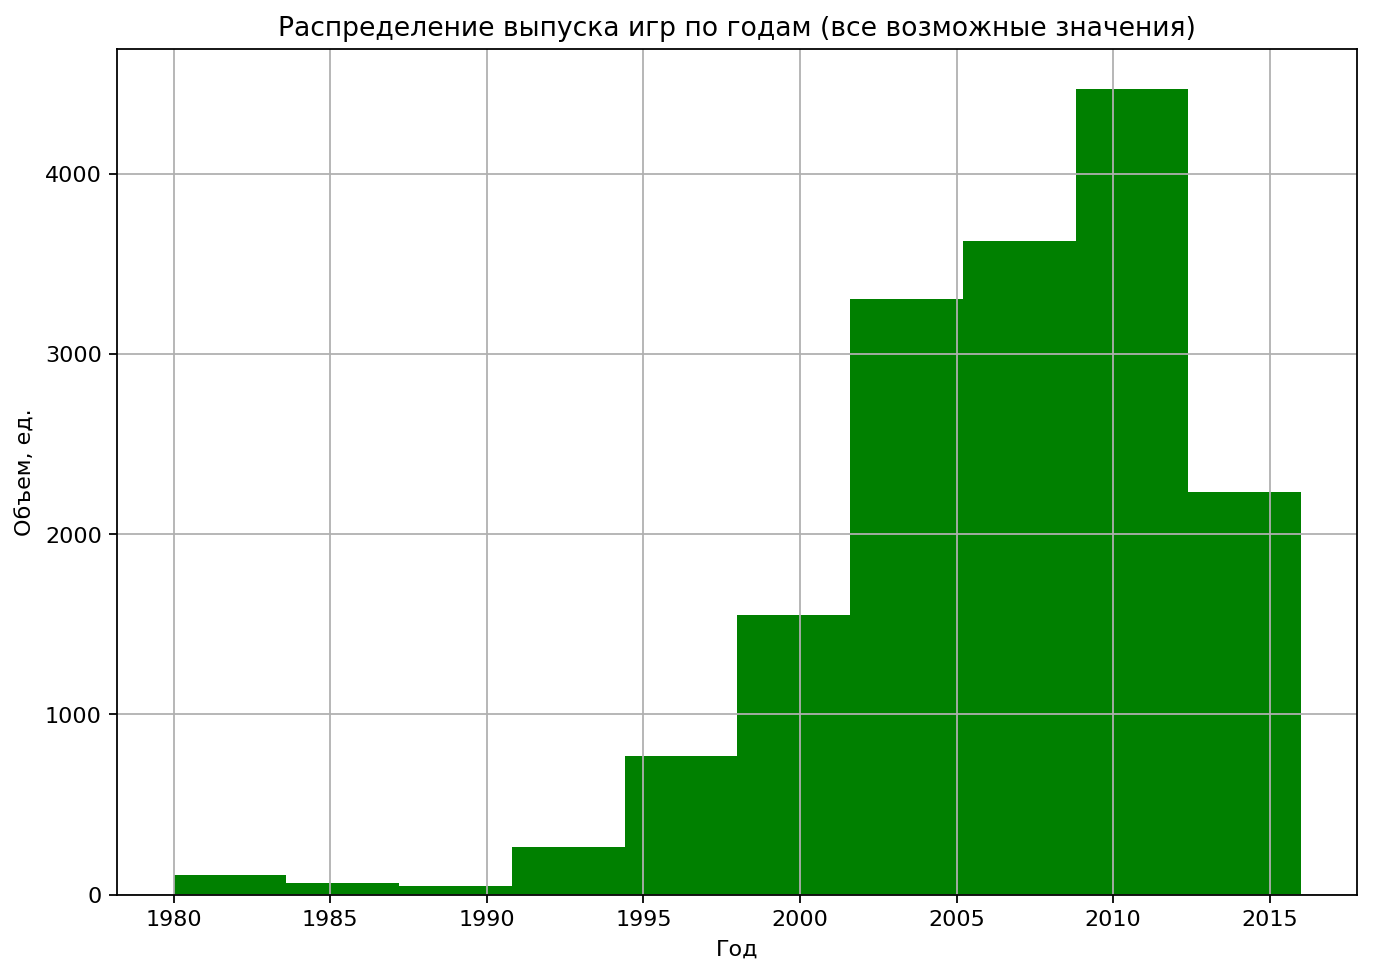

In [27]:
draw_hist(df_dates['year_of_release'], "Распределение выпуска игр по годам (все возможные значения)", 'Год')

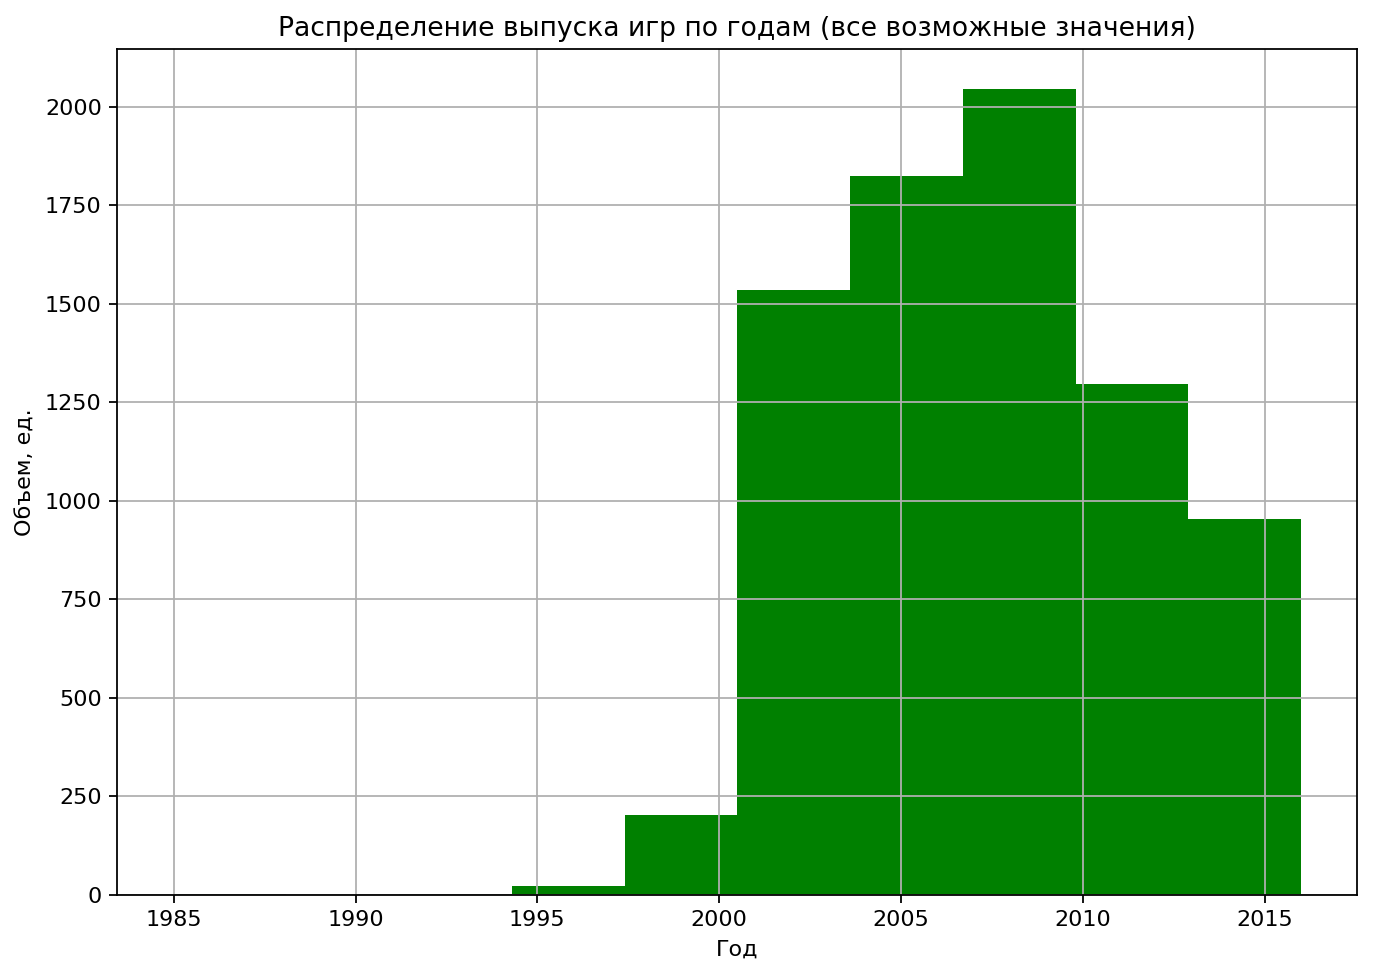

In [28]:
draw_hist(df['year_of_release'], "Распределение выпуска игр по годам (все возможные значения)", 'Год')

Попробуем описать то, что мы видим. 

Во-первых, информация по выпуску игр до 2000 года составляет небольшую часть от общего числа продаж. Отметим также, что к 2000 году рынок компьютерных игр стабилизировался, и на нём образовалось мейнстримные (по сей день) тенденции: конкуренция за пользователей ПК и консолей, а также конкуренция за пользователей консолей Playstation и Xbox.

Во-вторых, пиковое значение выпущенных игр на основании полученной выборки - середина нулевых в плоть до ранних десятых. Почему количество выпускаемых игр падает? С одной стороны, мы точно не можем сказать, возможно, наша выборка не репрезентативна. С другой стороны, стоимость производства игр неукоснимо растёт - для захвата внимания пользователя требуются инновационные технологии, которые не каждая студия может позволить. 

In [29]:
display(df_dates.groupby('year_of_release').count()['name'])

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

### Изучение продаж по платформам.

In [30]:
print("Информация по продажам на платформах в очищенном массиве:")
display(df.groupby('platform').count()['name'])

Информация по продажам на платформах в очищенном массиве:


platform
3DS      165
DC        14
DS       703
GBA      426
GC       437
PC       655
PS       185
PS2     1275
PS3      798
PS4      241
PSP      455
PSV      119
Wii      565
WiiU      90
X360     887
XB       702
XOne     161
Name: name, dtype: int64

In [31]:
print("Информация по продажам на платформах в сыром массиве:")
top_sales = df_dates.pivot_table(index='platform', values='sum_sales', aggfunc=['count', 'sum'])
top_sales.columns = ['count', 'sum']
top_sales = top_sales.sort_values(by=['sum'], ascending=False)
print(type(top_sales))
display(top_sales)

Информация по продажам на платформах в сыром массиве:
<class 'pandas.core.frame.DataFrame'>


,count,sum
platform,,
PS2,2127,1233.56
X360,1232,961.24
PS3,1306,931.34
Wii,1286,891.18
DS,2121,802.78
PS,1190,727.58
PS4,392,314.14
GBA,811,312.88
PSP,1193,289.53


Исходя из данных выше видим, что наиболее популяными платформами за всё время являются: PS2, XBOX360, PS3 и Wii. Изучем подробнее каждую платформу.

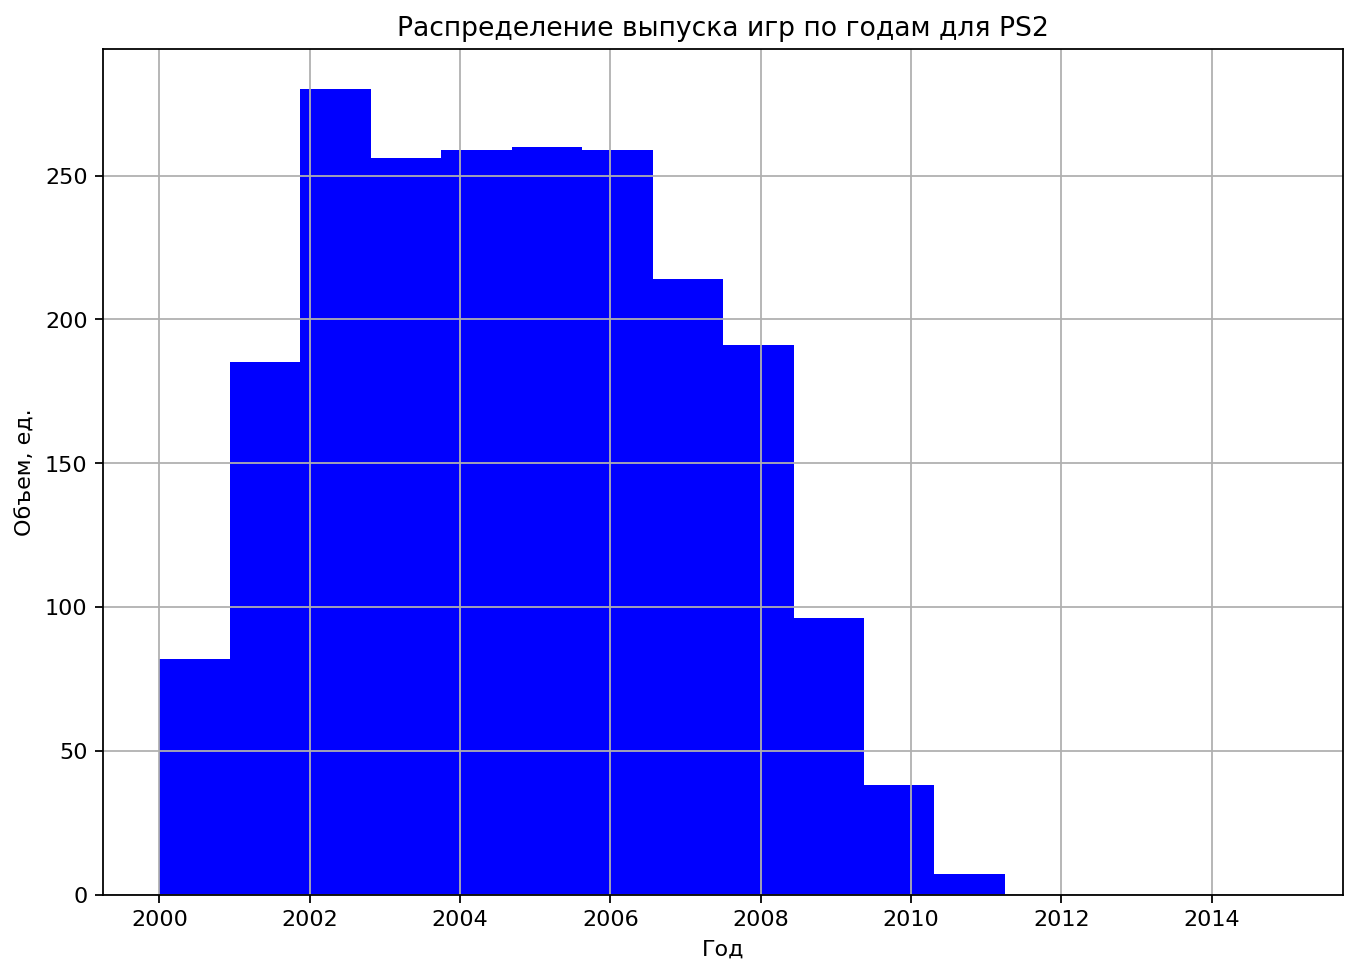

In [32]:
draw_hist(df_dates[df_dates['platform'] == "PS2"]['year_of_release'], "Распределение выпуска игр по годам для PS2", 'Год', h_range=(2000, 2015),
          bins=16, color='blue')

Игры на PS2 в настоящий момент не выпускаются потому, что у консоли есть её последователь - PS3. 

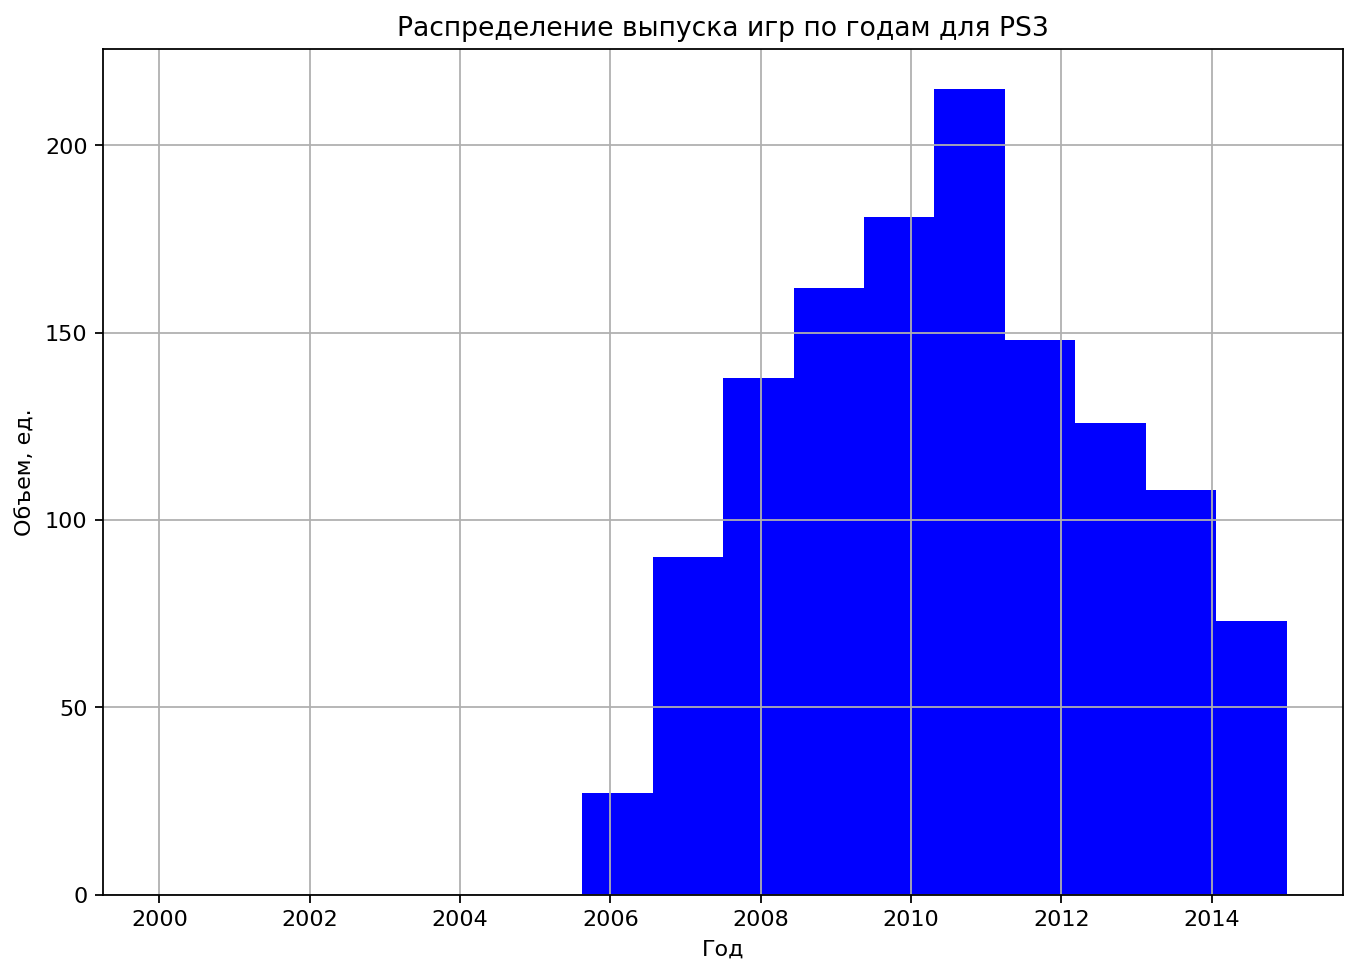

In [33]:
draw_hist(df_dates[df_dates['platform'] == "PS3"]['year_of_release'], "Распределение выпуска игр по годам для PS3", 'Год', h_range=(2000, 2015),
          bins=16, color='blue')

Для PS3 пиковой датой, когда наибольшее кол-во игр выпускалось - 2011 год, после - идёт спад. Значит, PS3 уже не актуальная консоль. Подозреваем, что всё дело в PS4...

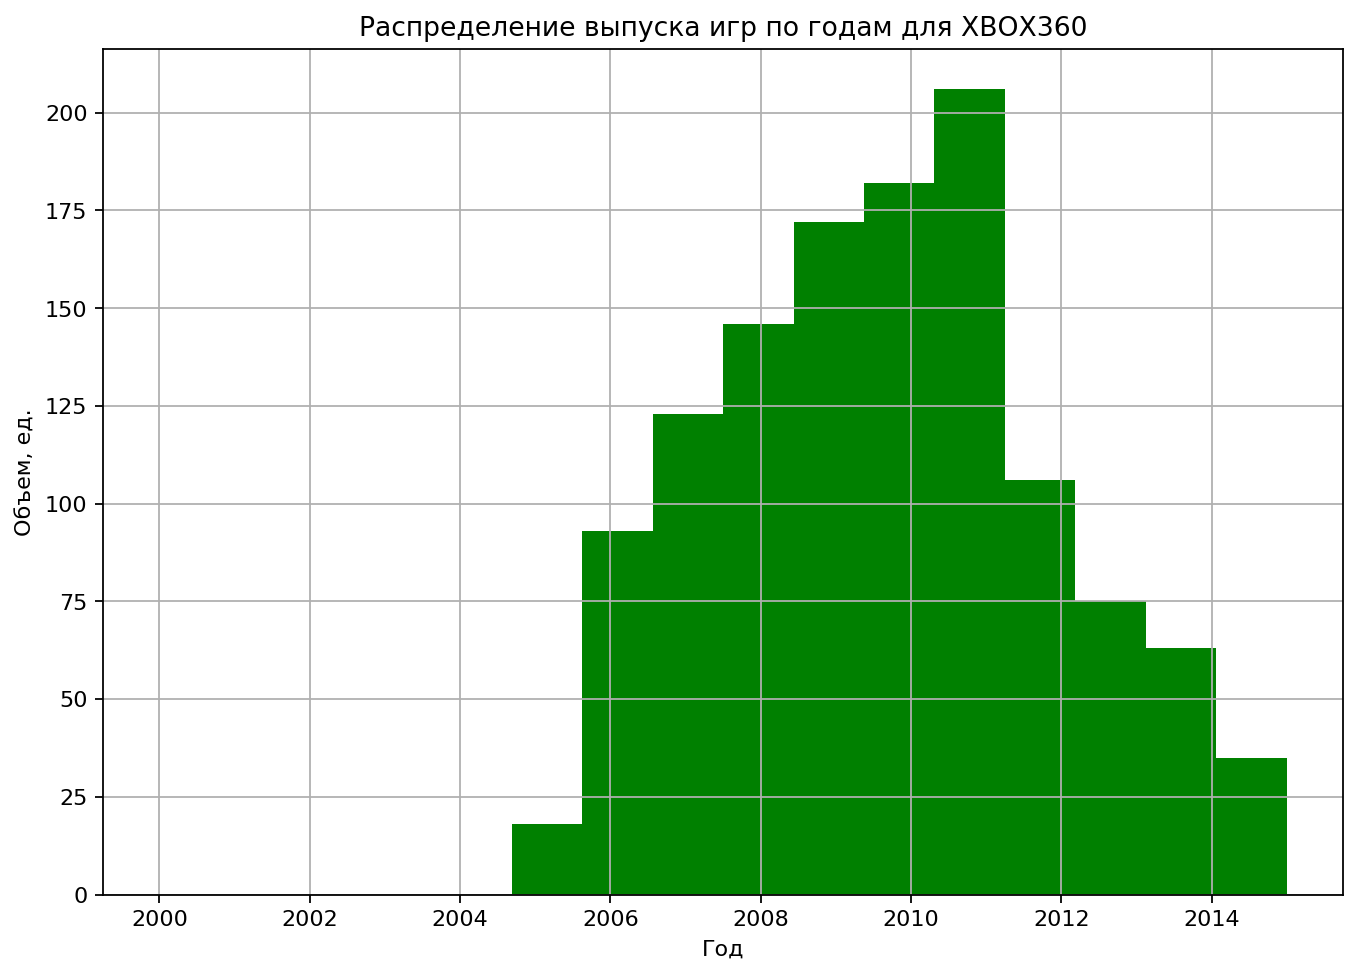

In [34]:
draw_hist(df_dates[df_dates['platform'] == "X360"]['year_of_release'], "Распределение выпуска игр по годам для XBOX360", 'Год', h_range=(2000, 2015),
          bins=16, color='green')

У xbox 360 такая же динамика, что и у PS3 - значит, есть новая итерация консолей от Micosoft. Похоже, дело в XONE...

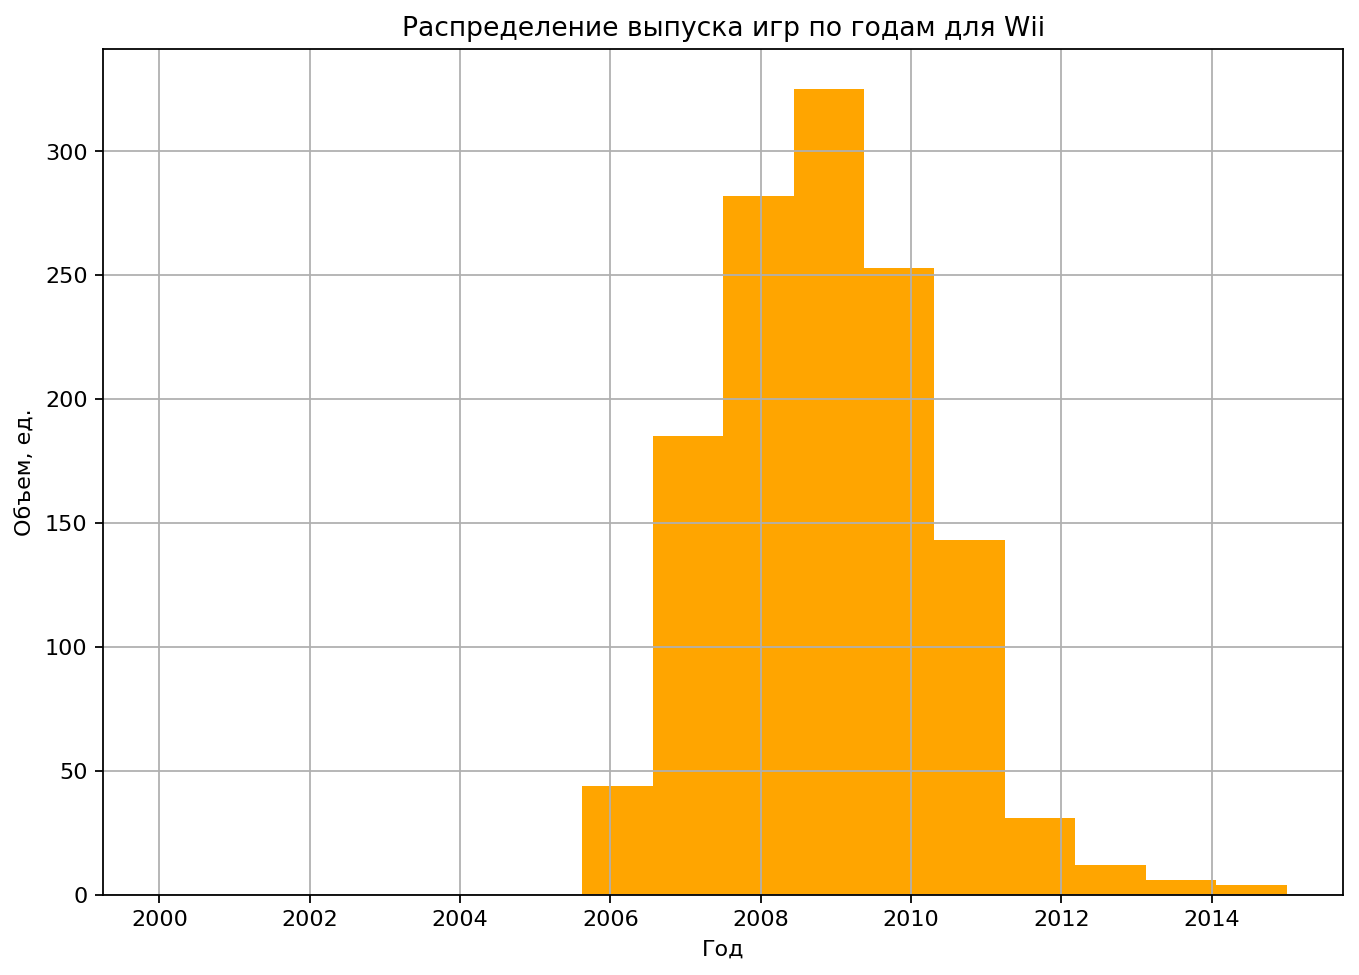

In [35]:
draw_hist(df_dates[df_dates['platform'] == "Wii"]['year_of_release'], "Распределение выпуска игр по годам для Wii", 'Год', h_range=(2000, 2015),
          bins=16, color='orange')

Жизненный цикл для Wii также прошёл. Поэтому нам нет необходимости смотреть на неё.

Но где же ПК? Давайте посмотрим на динамику по персональным компьютерам.

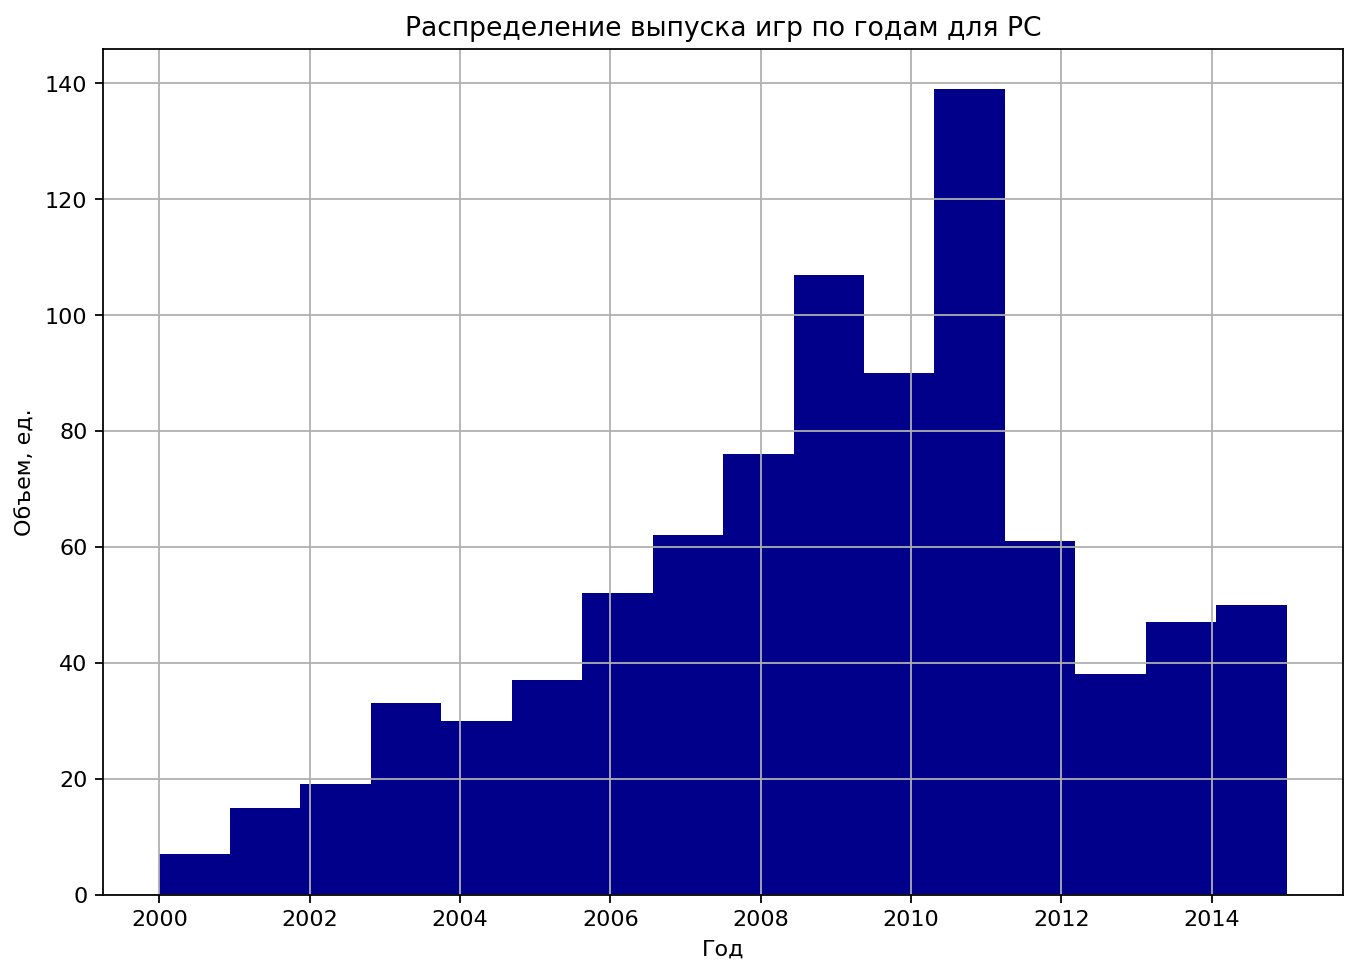

In [36]:
draw_hist(df_dates[df_dates['platform'] == "PC"]['year_of_release'], "Распределение выпуска игр по годам для PC", 'Год', h_range=(2000, 2015),
          bins=16, color='darkblue')

Компьютер, в отличие от консоли - постоянная переменная. Компьютеры на ОС Windows существуют с начала девяностых и являются популярной игровой платформой. Поэтому нам важно не забывать о ней.

Выше мы сделали предположение относительно того, какие консоли нам стоит рассматривать. Посмотрим на распределение для PS4 и XONE. А также WiiU и Nintendo 3DS

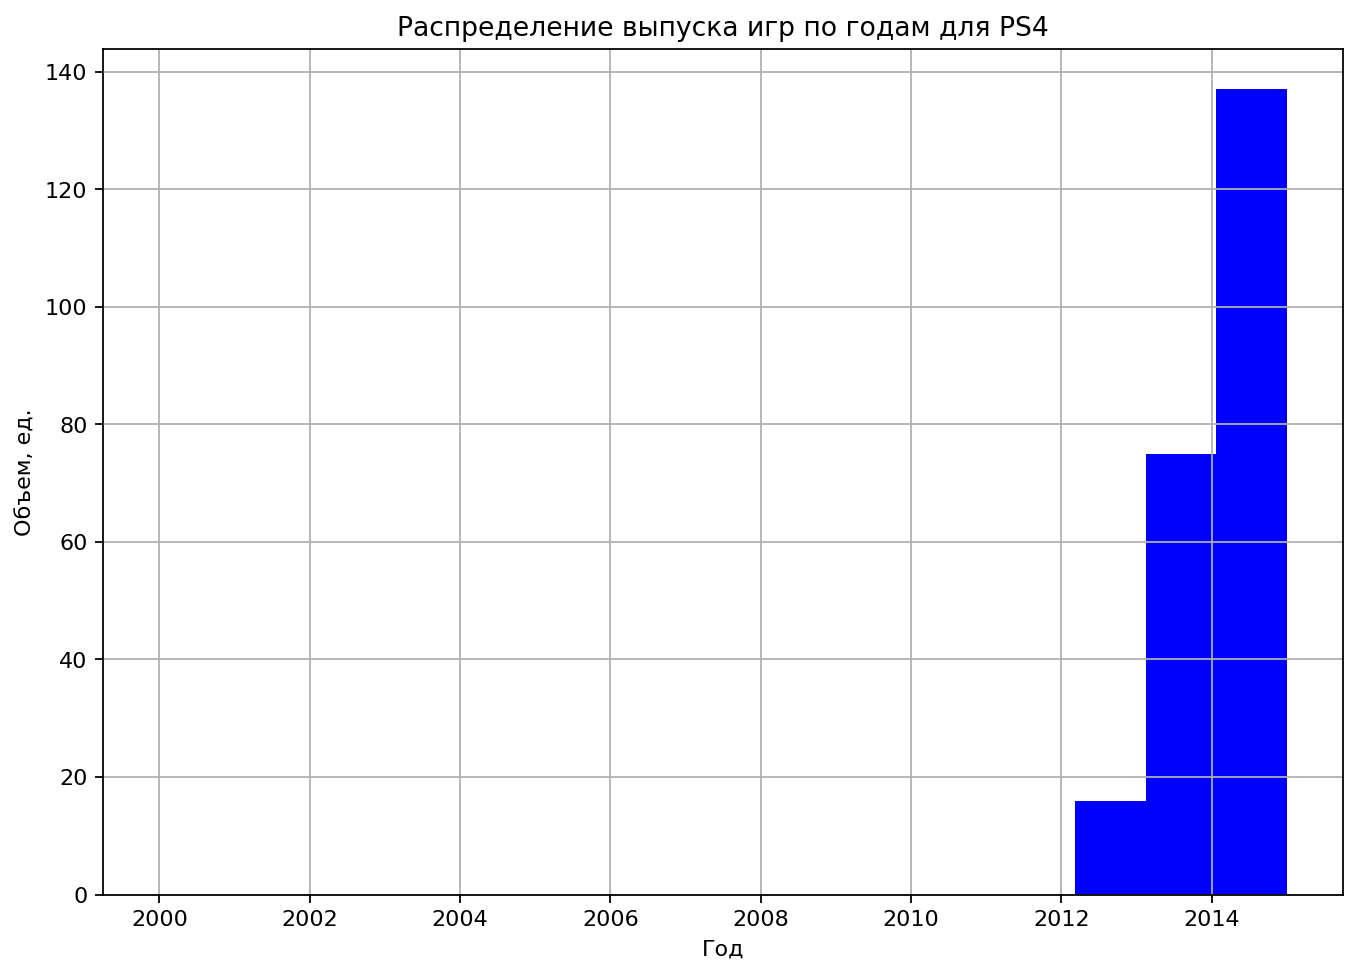

In [37]:
draw_hist(df_dates[df_dates['platform'] == "PS4"]['year_of_release'], "Распределение выпуска игр по годам для PS4", 'Год', h_range=(2000, 2015),
          bins=16, color='blue')

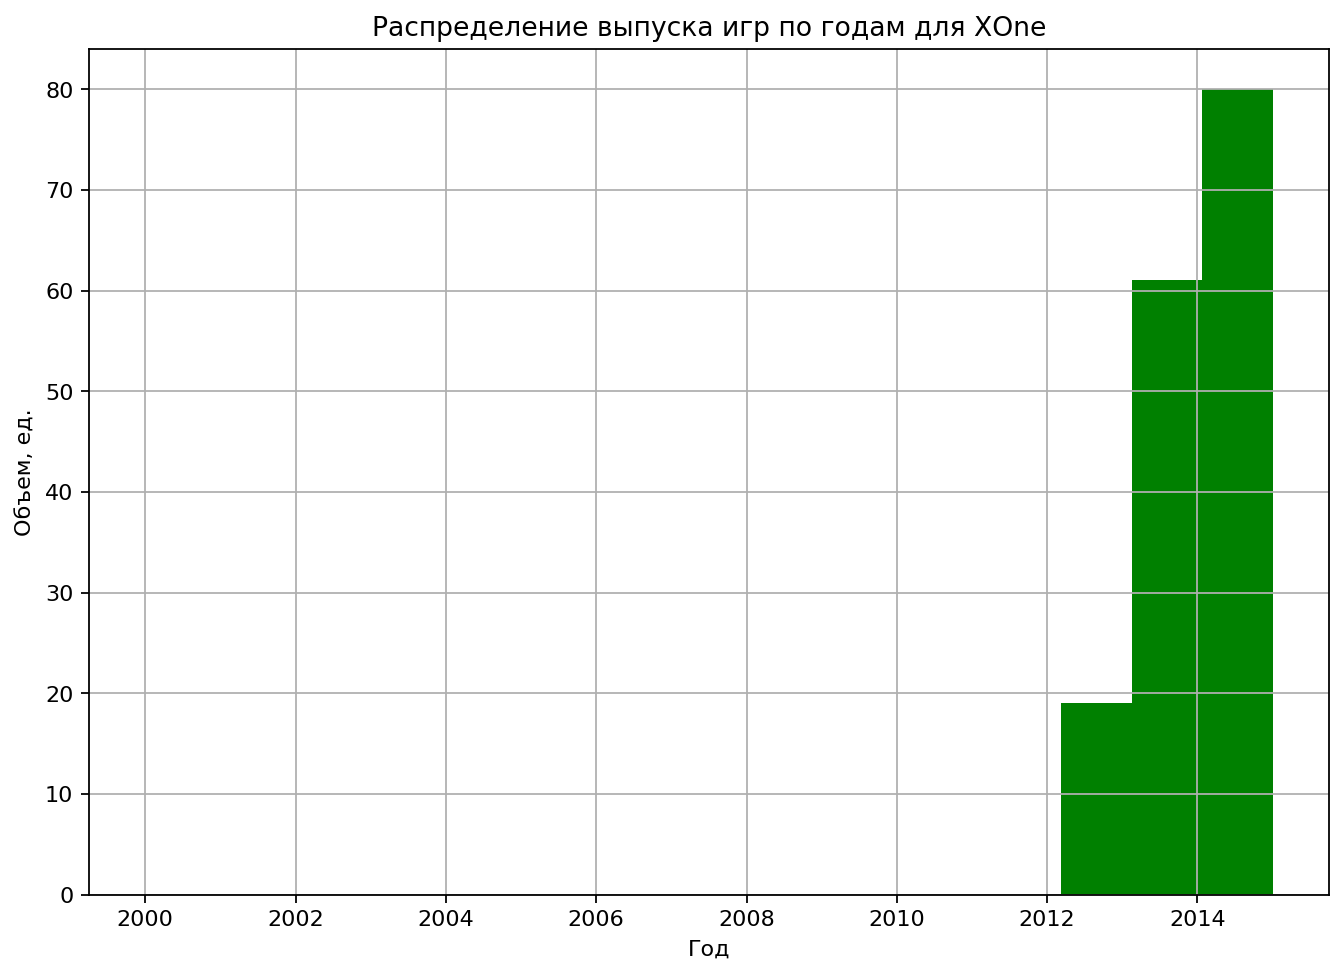

In [38]:
draw_hist(df_dates[df_dates['platform'] == "XOne"]['year_of_release'], "Распределение выпуска игр по годам для XOne", 'Год', h_range=(2000, 2015),
          bins=16, color='green')

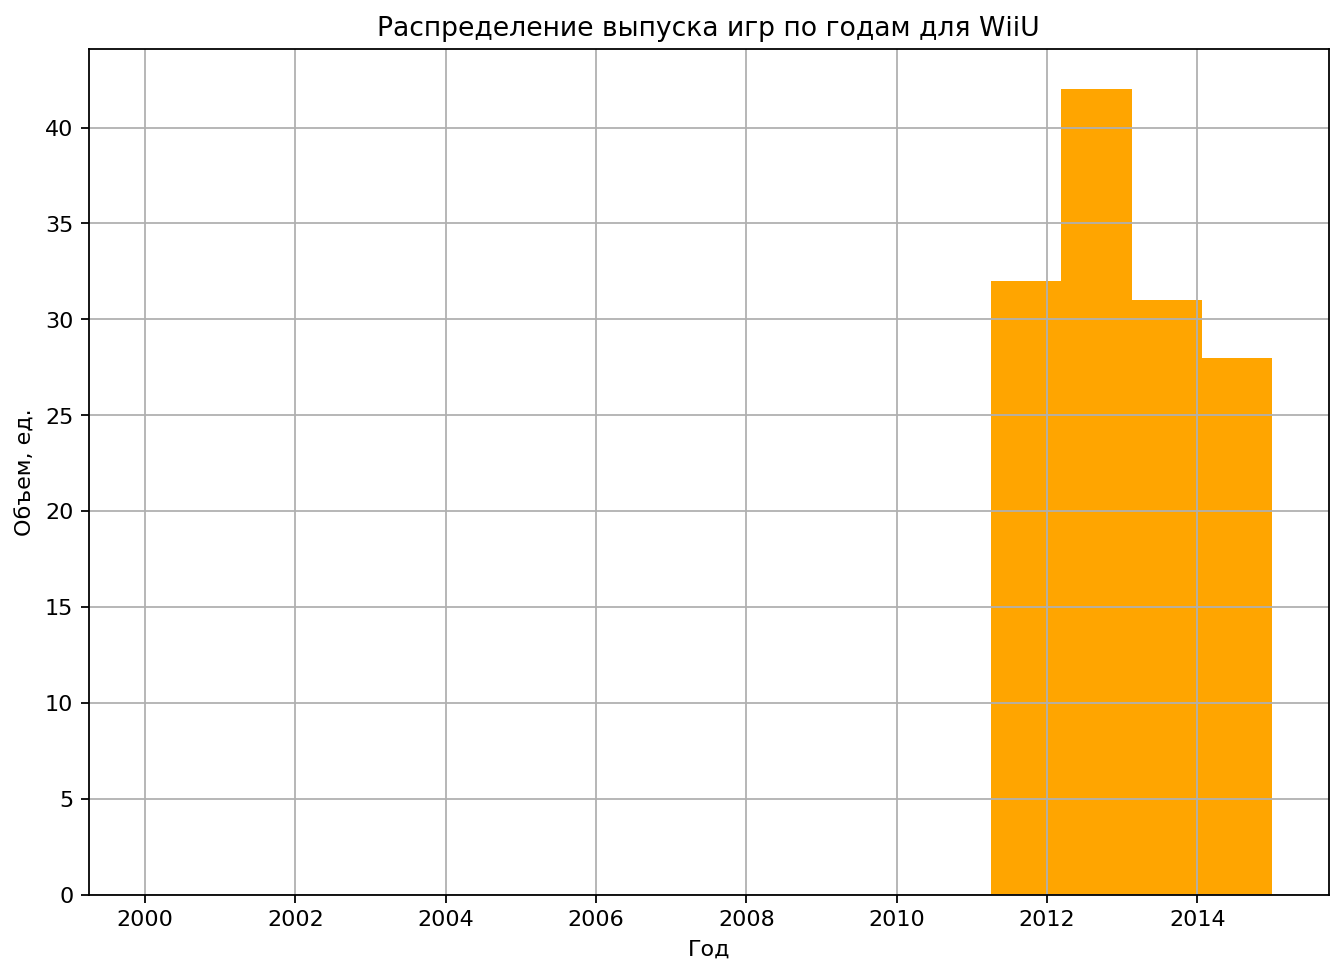

In [39]:
draw_hist(df_dates[df_dates['platform'] == "WiiU"]['year_of_release'], "Распределение выпуска игр по годам для WiiU", 'Год', h_range=(2000, 2015),
          bins=16, color='orange')

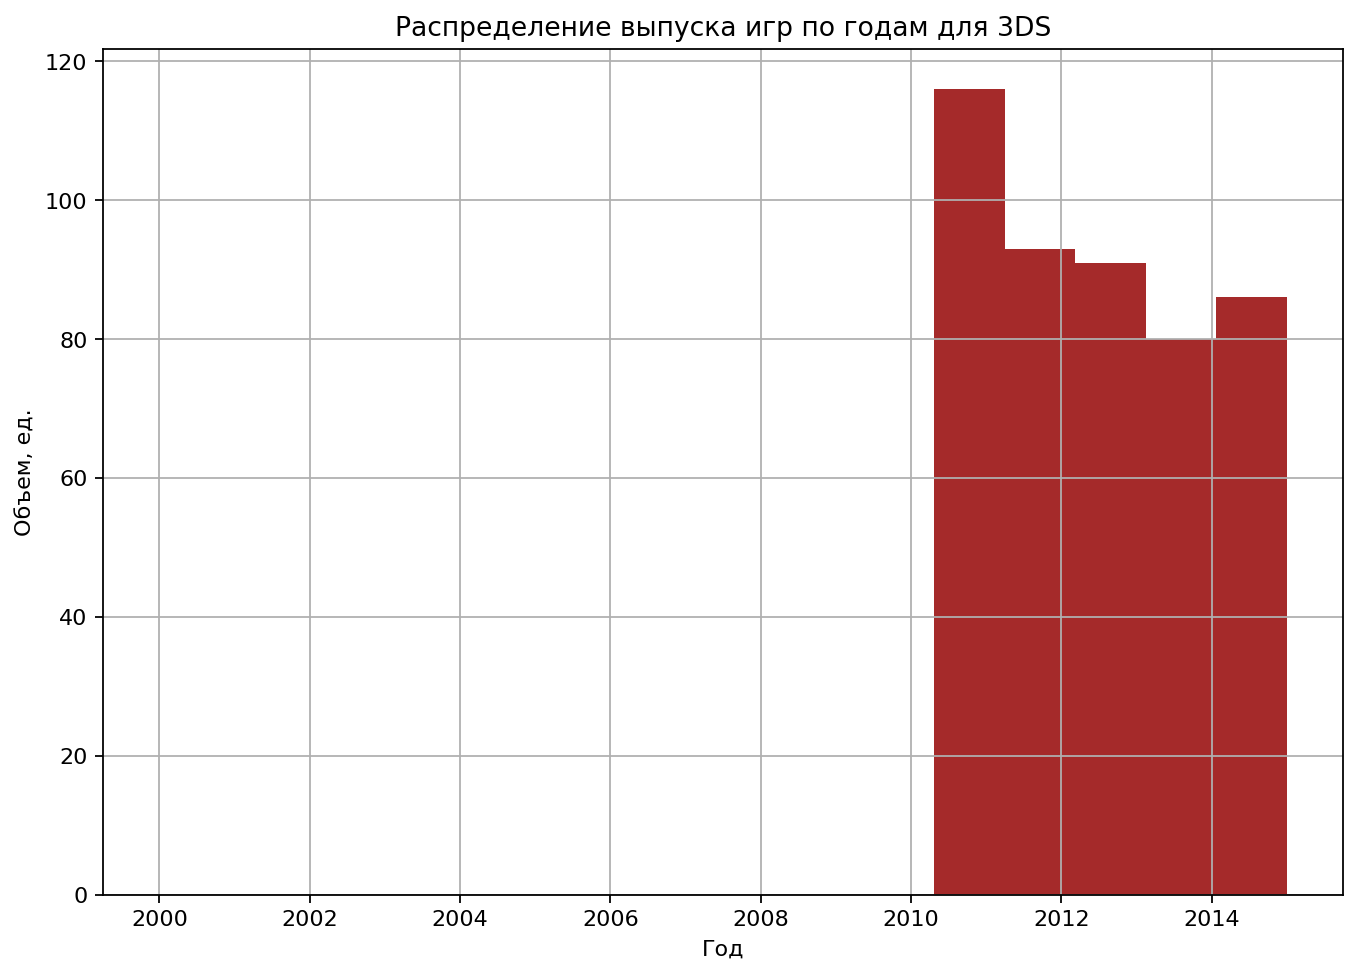

In [40]:
draw_hist(df_dates[df_dates['platform'] == "3DS"]['year_of_release'], "Распределение выпуска игр по годам для 3DS", 'Год', h_range=(2000, 2015),
          bins=16, color='brown')

3DS неожиданно оказалась в топе, а также - действующей консолью. Значит, её тоже нужно учитывать.

Таким образом, мы определили перечень наиболее популярных и перспективных (прибыльных) платформ:
1. PC - персональные компьютеры;
2. XOne - консоль от Miscrosoft, последователь X360;
3. PS4 - консоль от Sony, последователь PS3;
4. WiiU - коносль от Nintend, последователь Wii;


Таким образом, мы охватили все компании, занятые производством консолей последнего поколения, а также взяли ПК, так как ПК является постоянной платформой вот уже более 30 лет. 

При этом укажем, что для консолей PS4 и XOne **предполагаемый срок жизни** будет равен примерно 7-9 годам. Сами консоли вышли только в 2012 году. Поэтому 2017 год для данных консолей - некоторый перевал за середину жизненного цикла.

Отметим, что современные консоли от Miscosoft и Sony (PS5 и Xbox Series X) вышли в конце 2020 года. То есть наши расчеты приблизительно верны.

In [41]:
df_dates_full = df_dates
df_dates = df_dates.query('year_of_release >= 2012')

А теперь посмотрим на продажи во всех регионах для платформ c учетом выбранного актуального периода.

In [42]:
display(df_dates
        .pivot_table(index='platform', values='sum_sales', aggfunc=['count', 'sum'])
        .sort_values(('sum', 'sum_sales'), ascending=False)
       )

,count,sum
,sum_sales,sum_sales
platform,,
PS4,392,314.14
PS3,493,288.79
X360,292,236.54
3DS,396,194.61
XOne,247,159.32
WiiU,147,82.19
PC,250,62.65
PSV,411,49.18


### Динамика продаж перспективных консолей

Теперь посмотрим на то, как изменяется динамика по продажам игр для указанных выше платформ.

Для начала получим график, показывающий сумму продаж по всем регионам для всех указанных выше платформ.

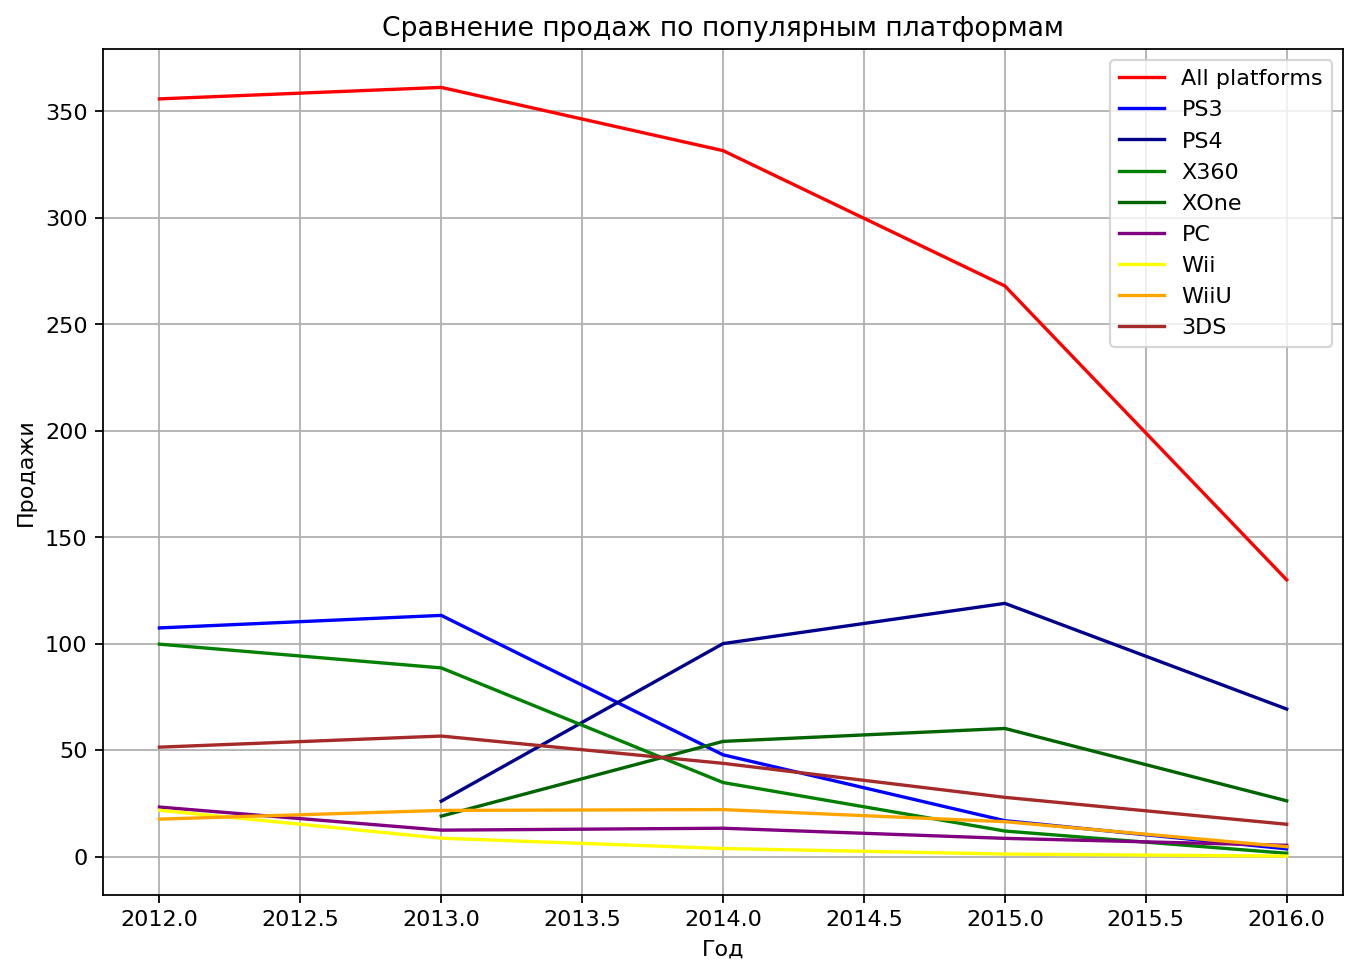

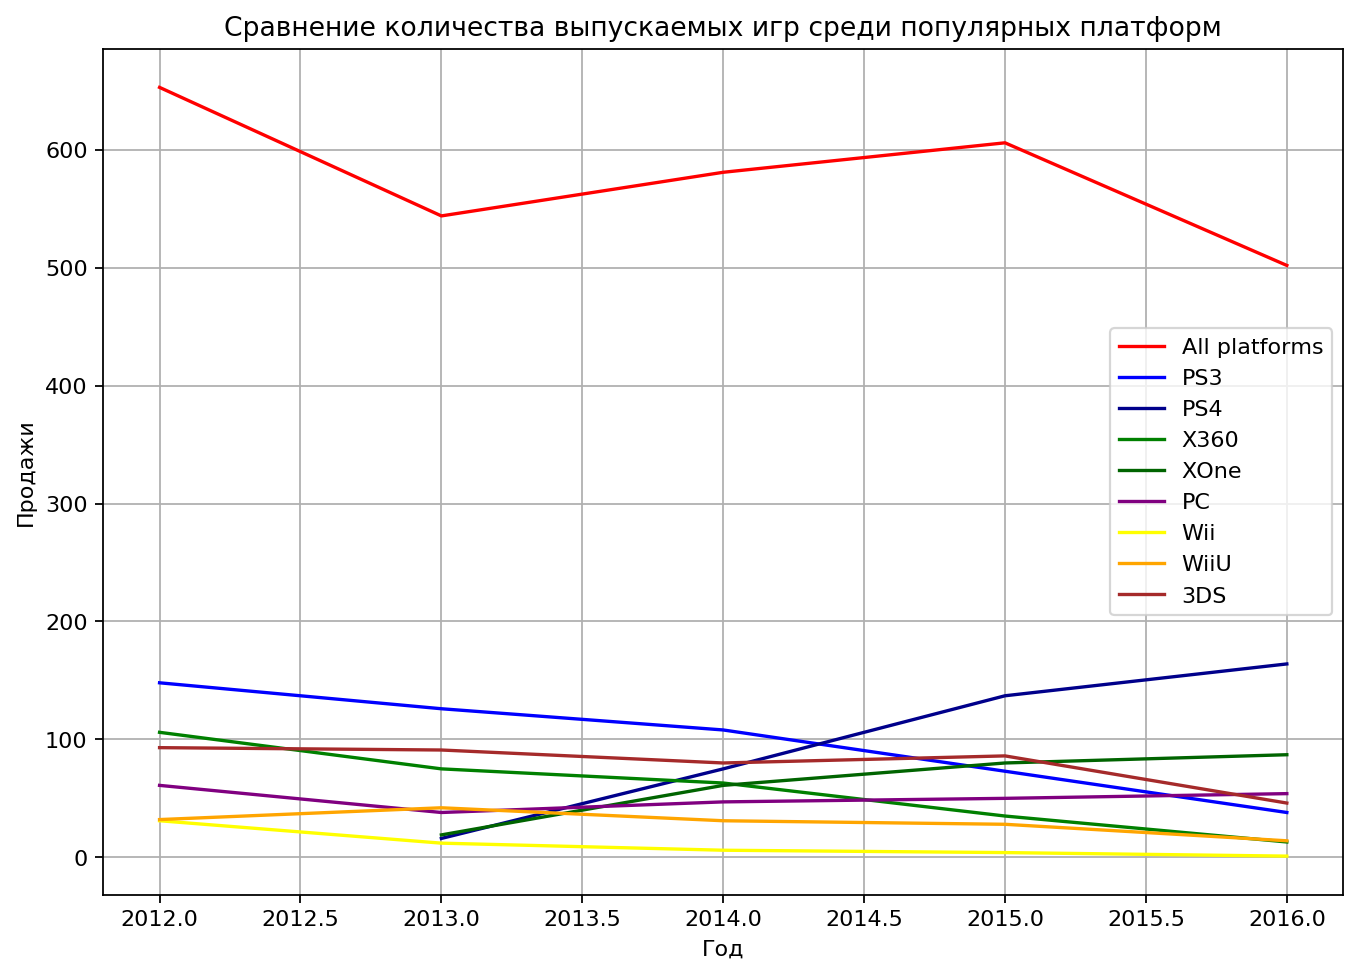

In [43]:
def look_platforms(data, overall=1, summary=1):
    '''
    
    '''
    if overall == 1:
        pl_list = [ df_dates['platform'].unique(), "PS3" , "PS4", "X360", "XOne", "PC", "Wii", "WiiU", "3DS"]
        labels= ['All platforms', "PS3", "PS4", "X360", "XOne", "PC", "Wii", "WiiU", "3DS"]
        colors = ['red', 'blue', 'darkblue', 'green', 'darkgreen','purple' , 'yellow', 'orange', 'brown']
    else:
        pl_list = [ "PS3" , "PS4", "X360", "XOne", "PC", "Wii", "WiiU", "3DS"]
        labels= [ "PS3", "PS4", "X360", "XOne", "PC", "Wii", "WiiU", "3DS"]
        colors = ['blue', 'darkblue', 'green', 'darkgreen','purple' , 'yellow', 'orange', 'brown']
    plt.figure(figsize=(10,7), dpi=160)
    plt.xlabel("Год")
    plt.ylabel("Продажи")
    plt.grid()
    i=0
    for x in pl_list:
        df = data.query('platform in @x')
        if summary == 1:
            plt.title("Сравнение продаж по популярным платформам")
            df = df.groupby(by="year_of_release")['sum_sales'].sum().reset_index(drop=False)
        else:
            plt.title("Сравнение количества выпускаемых игр среди популярных платформ")
            df = df.groupby(by="year_of_release")['sum_sales'].count().reset_index(drop=False)
        plt.plot(df['year_of_release'], df['sum_sales'], color=colors[i], label=labels[i])
        i+=1
    plt.legend()
    plt.show()
    plt.close() 
    
def look_sales(df, platform, color ):
    '''
    
    '''
    df = df_dates.query("platform == @platform")
    df = ds.groupby(by="year_of_release")['sum_sales'].count().reset_index(drop=False)
    draw_plot(df['year_of_release'], df['sum_sales'], title="Объемы продаж для {}".format(platform)
              , xlabel="Год", ylabel="Млн. копий", color=color)

    
look_platforms(df_dates, overall=1, summary=1)
look_platforms(df_dates, overall=1, summary=0)

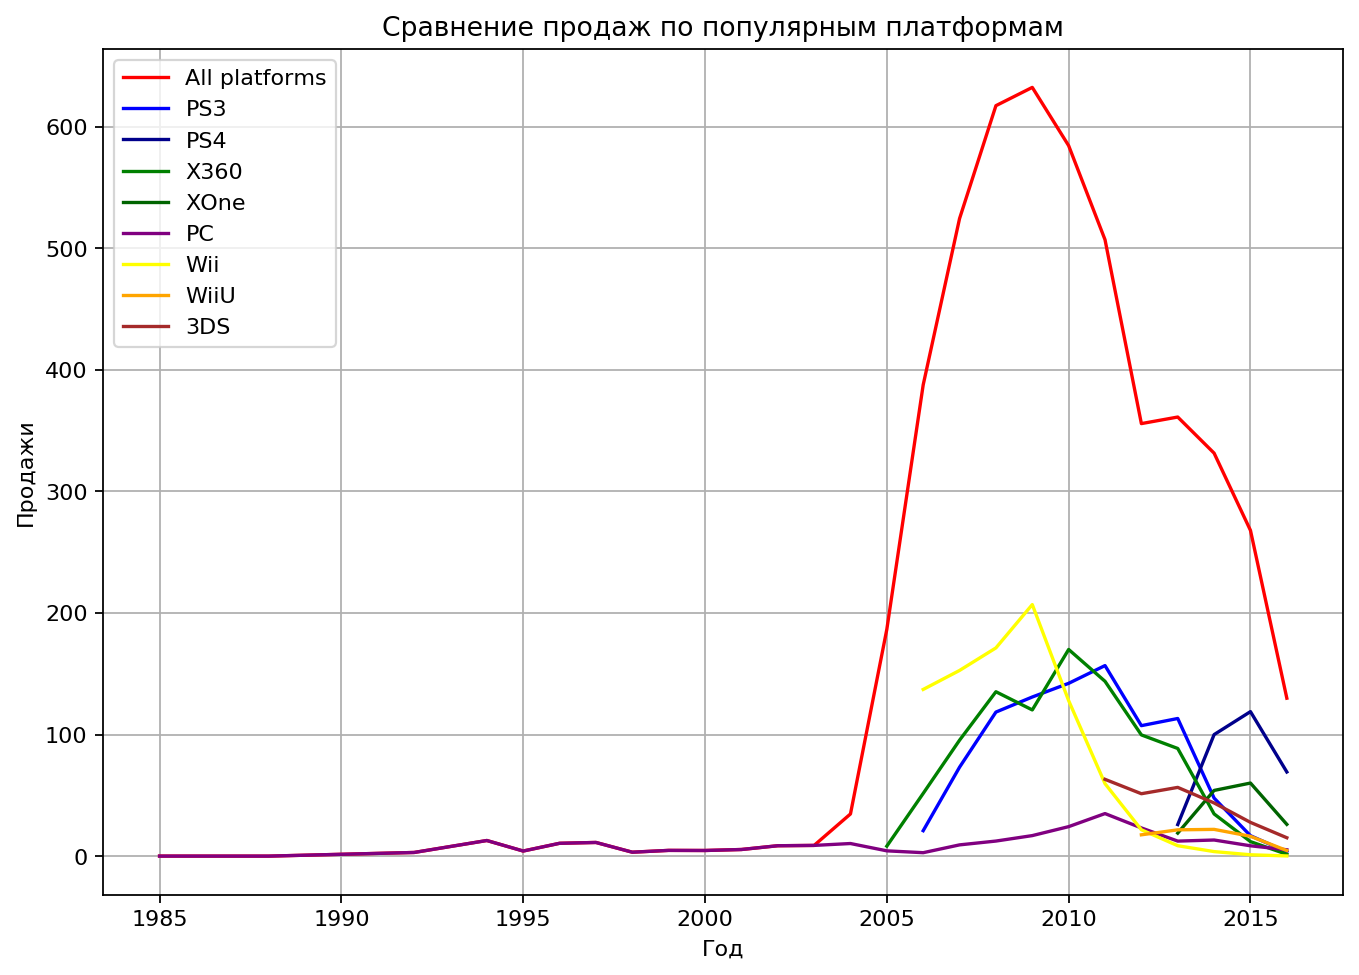

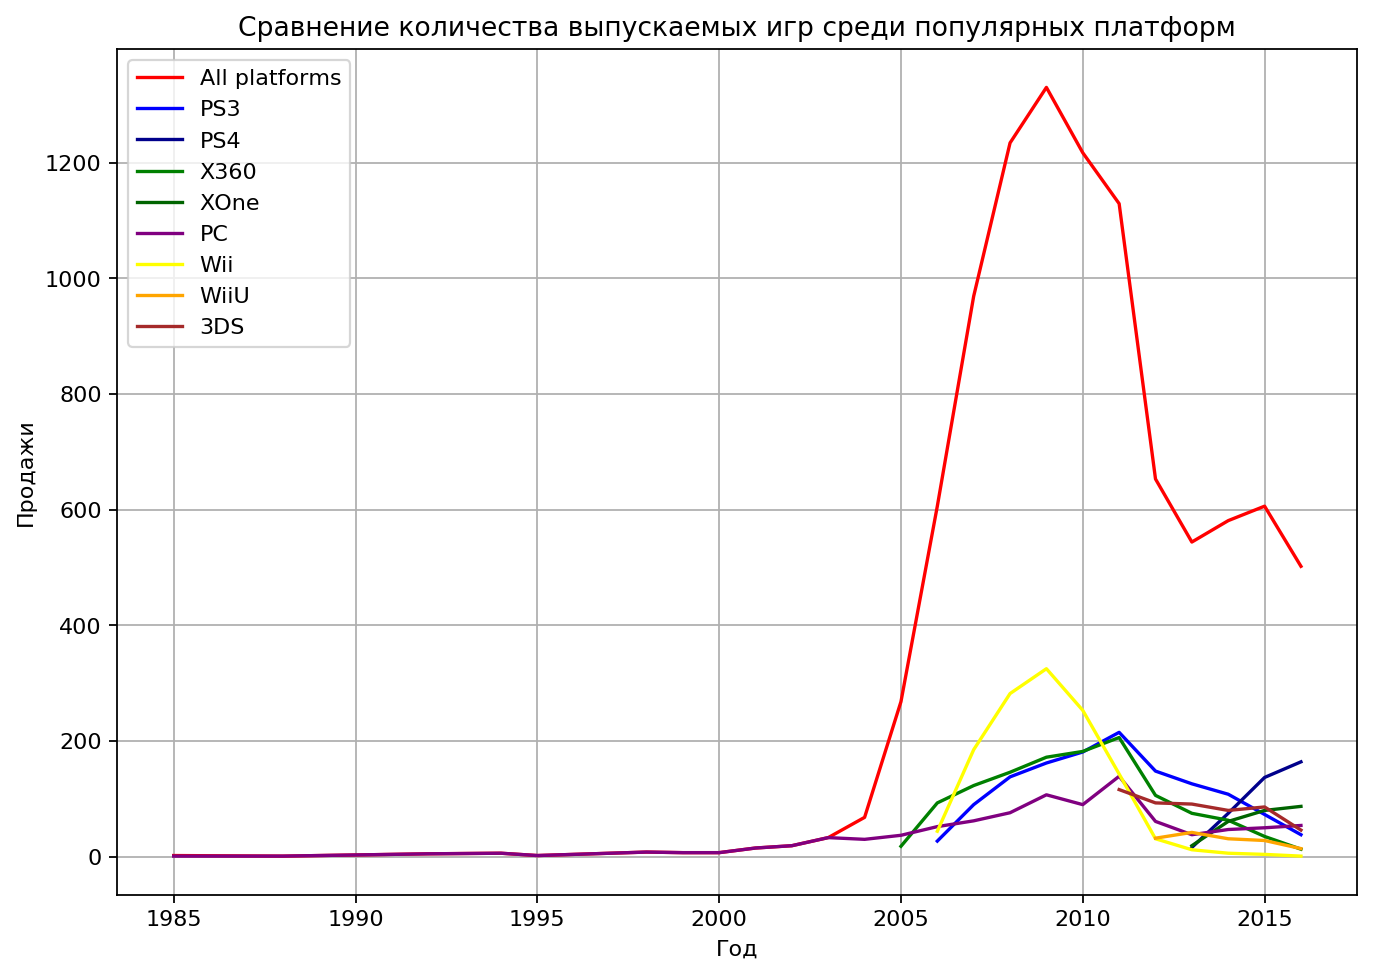

In [44]:
look_platforms(df_dates_full, overall=1, summary=1)
look_platforms(df_dates_full, overall=1, summary=0)

Что интересного мы видим:

Динамика продаж после 2012 года - отрицательная, общее число продаж, а также общее количество выпускаемых игр падает по всем платформам. Выше мы предполагали, что количество проданных игр уменьшается вследствие увеличения стоимости разработки.

Скорее всего, мы имеем дело с неполными данными за 2016 год, поэтому наблюдается вот такое падение.

Также по данному периоду мы видим закономерное падение спроса и количества игр для платформ старого поколения. Получается, что 2014 год стал датой окончательного перехода на платформы нового поколения: далее игры на старые платформы выпускались только в случае, если они и так разрабатывались под них.

Отдельно отметим неожиданно выскочившую из-за угла платформу 3DS. Количество игр на неё, ровно как и продажи, падают, хотя платформа всё ещё является действующей.

Поэтому далее при прогнозировании мы будем ориентироваться только на новые платформы от Microsoft и Sony, а также на ПК и WiiU.

In [45]:
pl_list = ["PS4","XOne", "PC","WiiU"]
df_dates_full = df_dates
df_dates = df_dates.query('platform in @pl_list')

### Построение ящика "с усами"

Построим боксплоты для дальнейшей работы с данными.

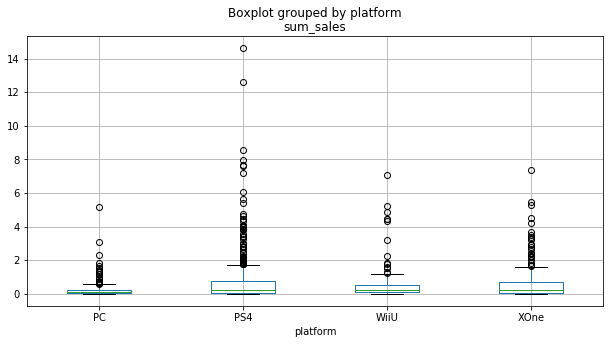

In [46]:
df_dates.boxplot('sum_sales', by='platform', figsize=(10,5), showfliers=True)

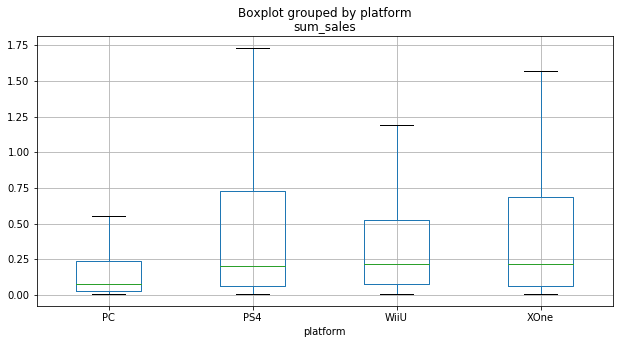

In [47]:
df_dates.boxplot('sum_sales', by='platform', figsize=(10,5), showfliers=False)

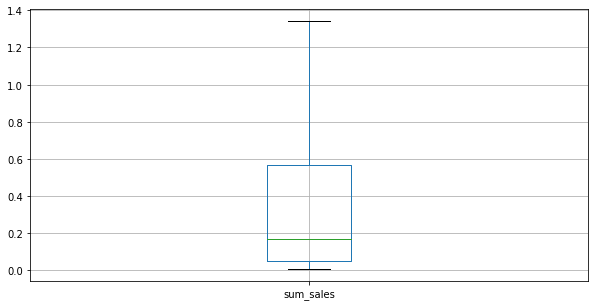

In [48]:
df_dates.boxplot('sum_sales', figsize=(10,5), showfliers=False)

Что мы имеем:

Лучше всего продаются игры на PS4 и XOne. По этим платформам разница между квартилями не так высока. Однако у PS4 есть явное преимущество. 

Хуже всего продаются игры на PC, и на это есть свои причины. Дело в том, что игры на PC очень легко "спиратить", то есть скачать взломанную версию игры и пройти её. Есть множество историй про то, как игры взламывались в первый же день, а также - как разработчики использовали инновационные способы защиты типа Denuvo. 

Отметим также, что WiiU в целом по продажам схожа с XOne, однако считается, что консоль от Nintendo - это что-то "другое". Нам нужно доказать этот тезис позже.

### Корреляция отзывов на продажи внутри одной платформы

Выше мы работали с датафреймом, который не подвергался никаким изменениям в части количества входных данных. Это связано с тем, что для анализа спроса и выпуска игр у нас была доступна вся информация. 

В случае с рейтингом по играм на платформах у нас больше ограничений, поэтому количество строк в датафрейме резко упало до 7 тысяч. 

Применим те же ограничения, которые мы наложили на df_dates, для df.

In [49]:
df_full = df
df = df.query('(year_of_release >= 2012) and (platform in @pl_list)')

In [50]:
brief(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666 entries, 27 to 7872
Data columns (total 12 columns):
name               666 non-null object
platform           666 non-null object
year_of_release    666 non-null int64
genre              666 non-null object
na_sales           666 non-null float64
eu_sales           666 non-null float64
jp_sales           666 non-null float64
other_sales        666 non-null float64
critic_score       666 non-null int64
user_score         666 non-null object
rating             666 non-null object
sum_sales          666 non-null float64
dtypes: float64(5), int64(2), object(5)
memory usage: 67.6+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
27,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
51,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
61,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66
62,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85,5,E,7.60
69,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87,6.5,M,7.17


Количество дубликатов - 0


Получили всего 661 запись, что по сравнению с 16 тысячами - меньше 10% от всех данных. Посмотрим поближе на разбиение по платформам. 

In [51]:
display(df.pivot_table(index='platform', values='sum_sales', aggfunc='count'))

,sum_sales
platform,
PC,174
PS4,241
WiiU,90
XOne,161


89 записей для WiiU, совсем мало. Тогда попробуем посмотреть на то, сколько игр у нас было без каких-либо именений в части удаления NaN. 

In [52]:
display(df_dates.pivot_table(index='platform', values='sum_sales', aggfunc='count'))

,sum_sales
platform,
PC,250
PS4,392
WiiU,147
XOne,247


Получили 1036 значений, что также меньше 10% от всех данных. Значит, у нас совсем немного игр удовлетворяет условию.

Изучим корреляцию от количества проданных копий по каждой платформе.

In [77]:
def corr_look(df, platform):
    display(df[df['platform'] == platform]
     .corr()['sum_sales']
     .to_frame()
     .sort_values('sum_sales',ascending=False)
     .dropna()
    )

def display_scatter(x,y, s_title, s_xlabel, s_ylabel, dpi=160, figsize=(9,7), alpha=1):
    plt.figure(figsize=figsize, dpi=dpi)
    # В случае с scatter никак не получалось вывести нормально xlabel и ylabel, использовал знания со stackoverflow
    plt.gca().update(dict(title=s_title, xlabel=s_xlabel, ylabel=s_ylabel))
    plt.scatter(x,y, alpha=alpha)
    plt.xticks([])
    plt.show()
    plt.close()    
    
def corr_and_scatt(df, platform):
    corr_look(df, platform)
    display_scatter(df[df['platform'] == platform]['user_score'], df[df['platform'] == platform]['sum_sales'],
                   s_title="Диаграмма рассеивания для платформы {} по рейтингу пользователей".format(platform), 
                   s_xlabel="Количество продаж", s_ylabel="Рейтинг пользователей")
    display_scatter(df[df['platform'] == platform]['user_score'], df[df['platform'] == platform]['sum_sales'],
                   s_title="Диаграмма рассеивания для платформы {} по рейтингу критиков".format(platform), 
                   s_xlabel="Количество продаж", s_ylabel="Рейтинг пользователей")

,sum_sales
sum_sales,1.000000
other_sales,0.997782
eu_sales,0.951449
na_sales,0.892879
jp_sales,0.591802
critic_score,0.403885
year_of_release,-0.235264


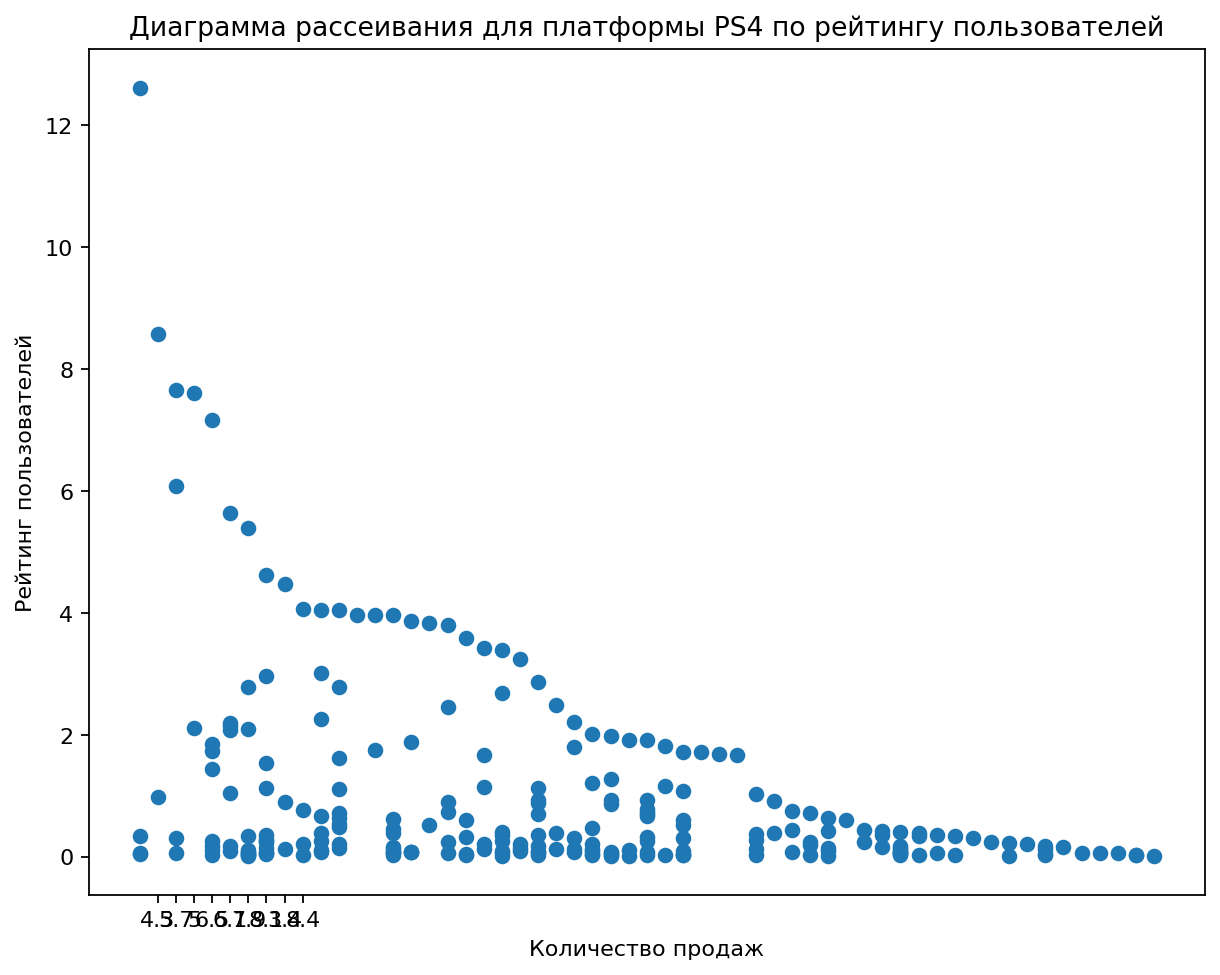

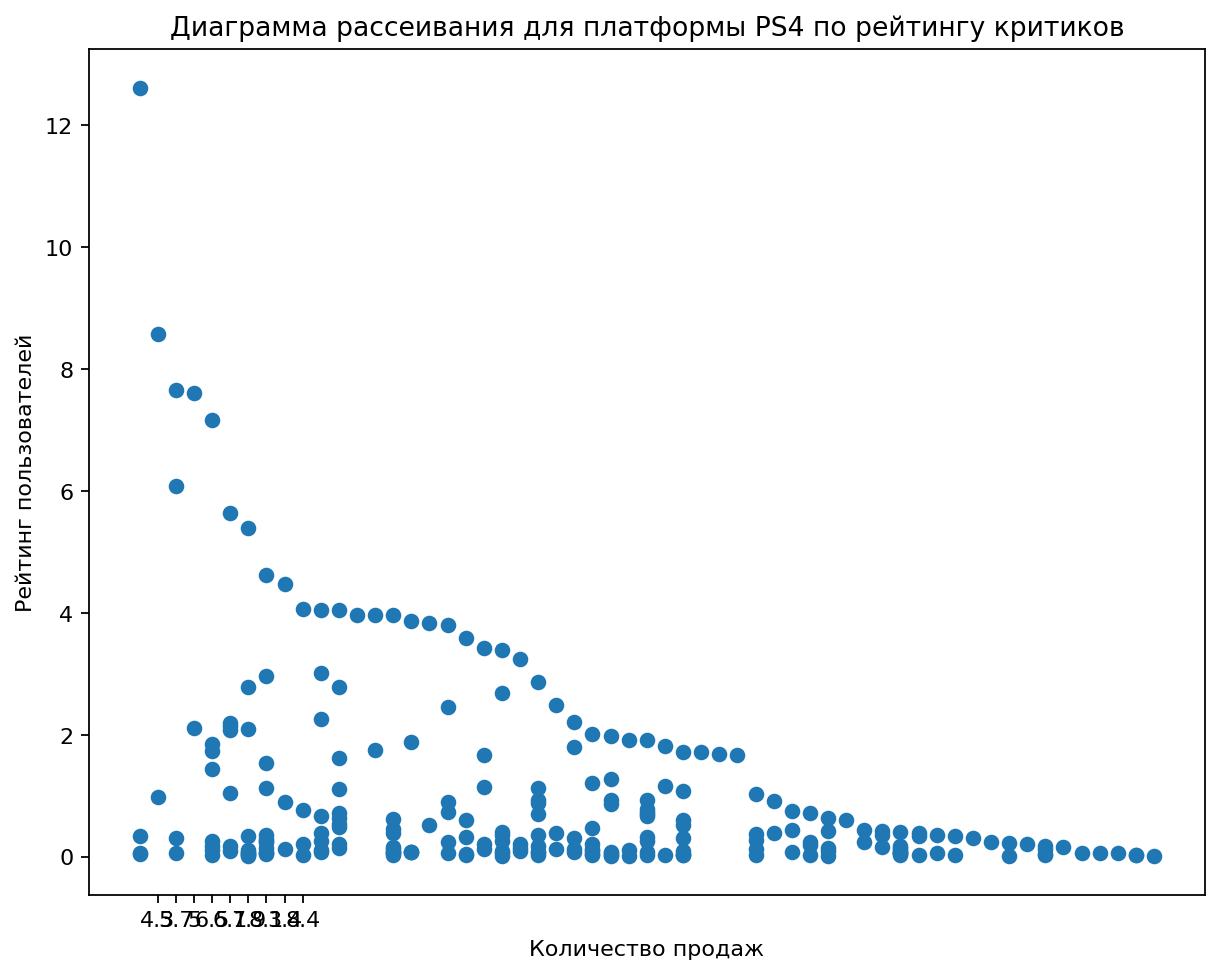

In [76]:
corr_and_scatt(df, "PS4")

,sum_sales
sum_sales,1.000000
other_sales,0.993138
na_sales,0.956530
eu_sales,0.864864
jp_sales,0.428794
critic_score,0.412072
year_of_release,-0.255469


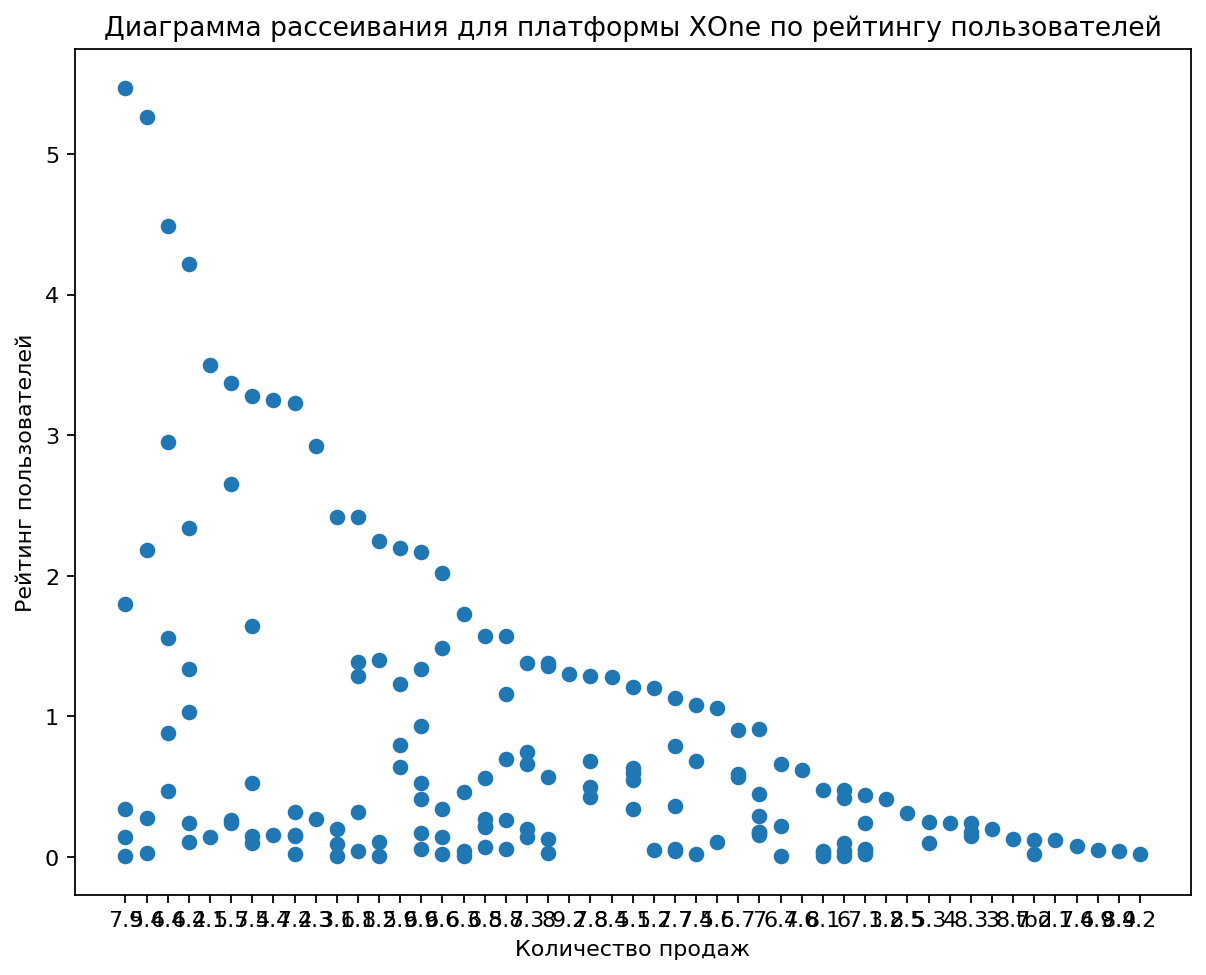

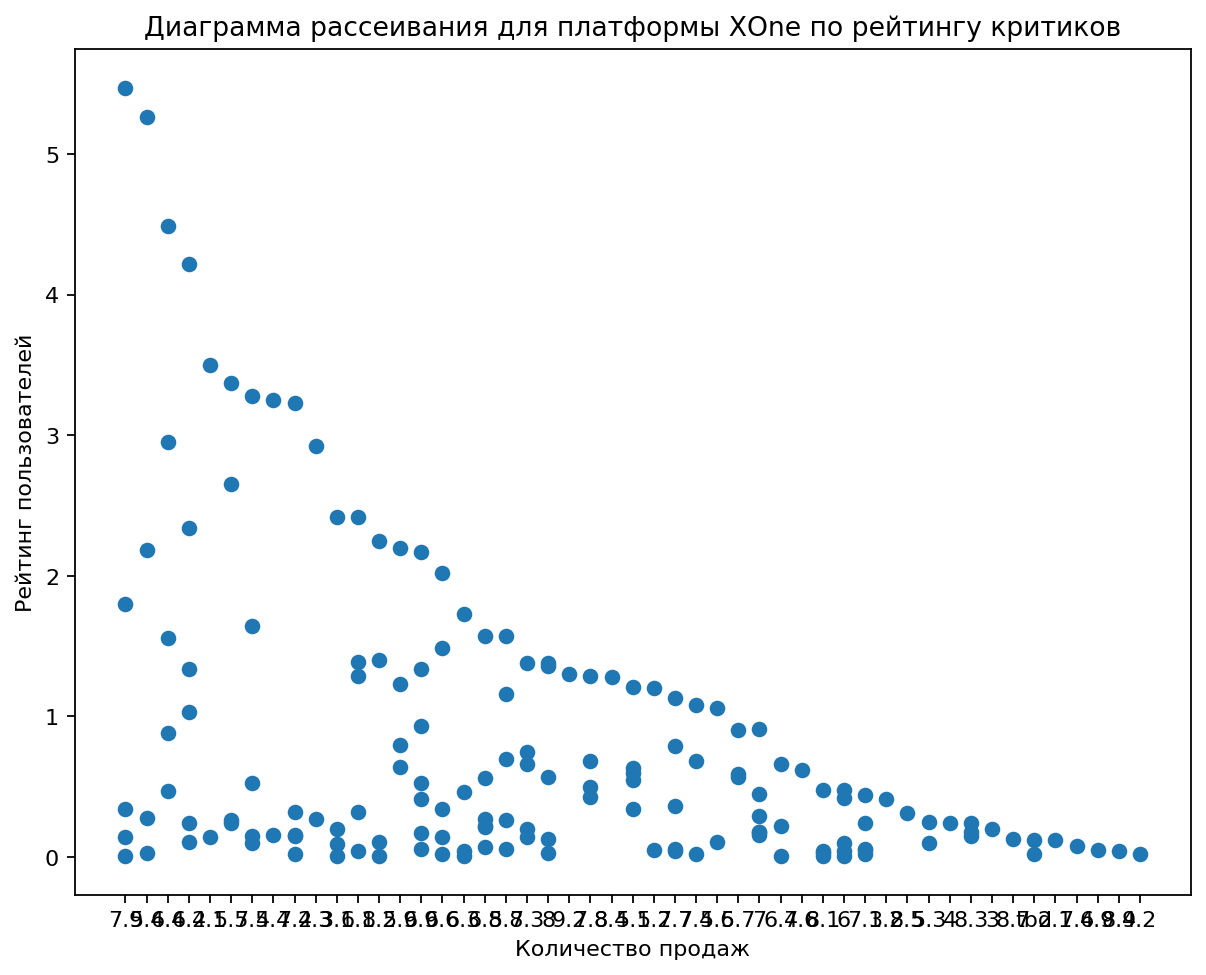

In [55]:
corr_and_scatt(df, "XOne")

,sum_sales
sum_sales,1.000000
eu_sales,0.989062
other_sales,0.988316
na_sales,0.981023
jp_sales,0.906888
critic_score,0.348380
year_of_release,-0.019617


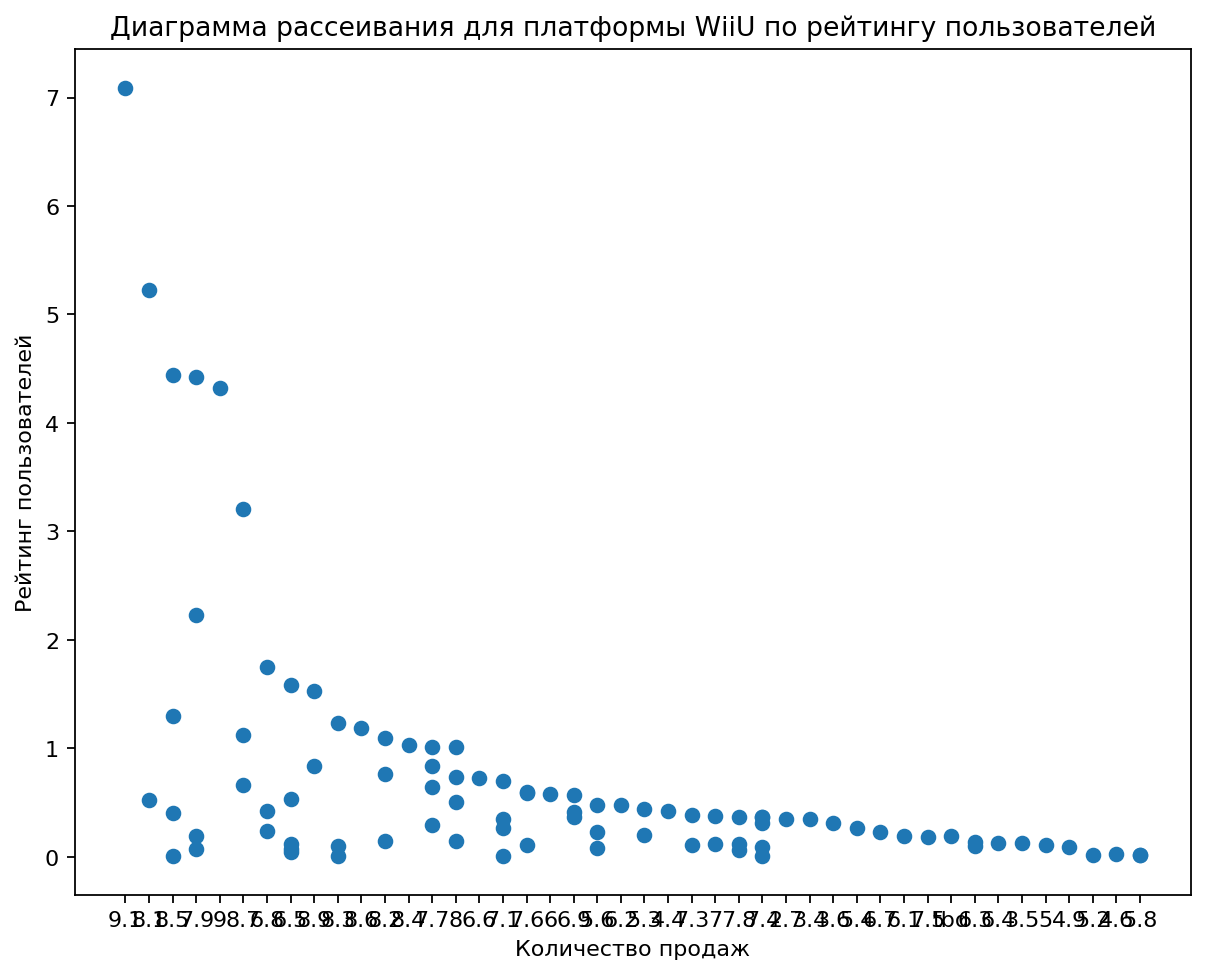

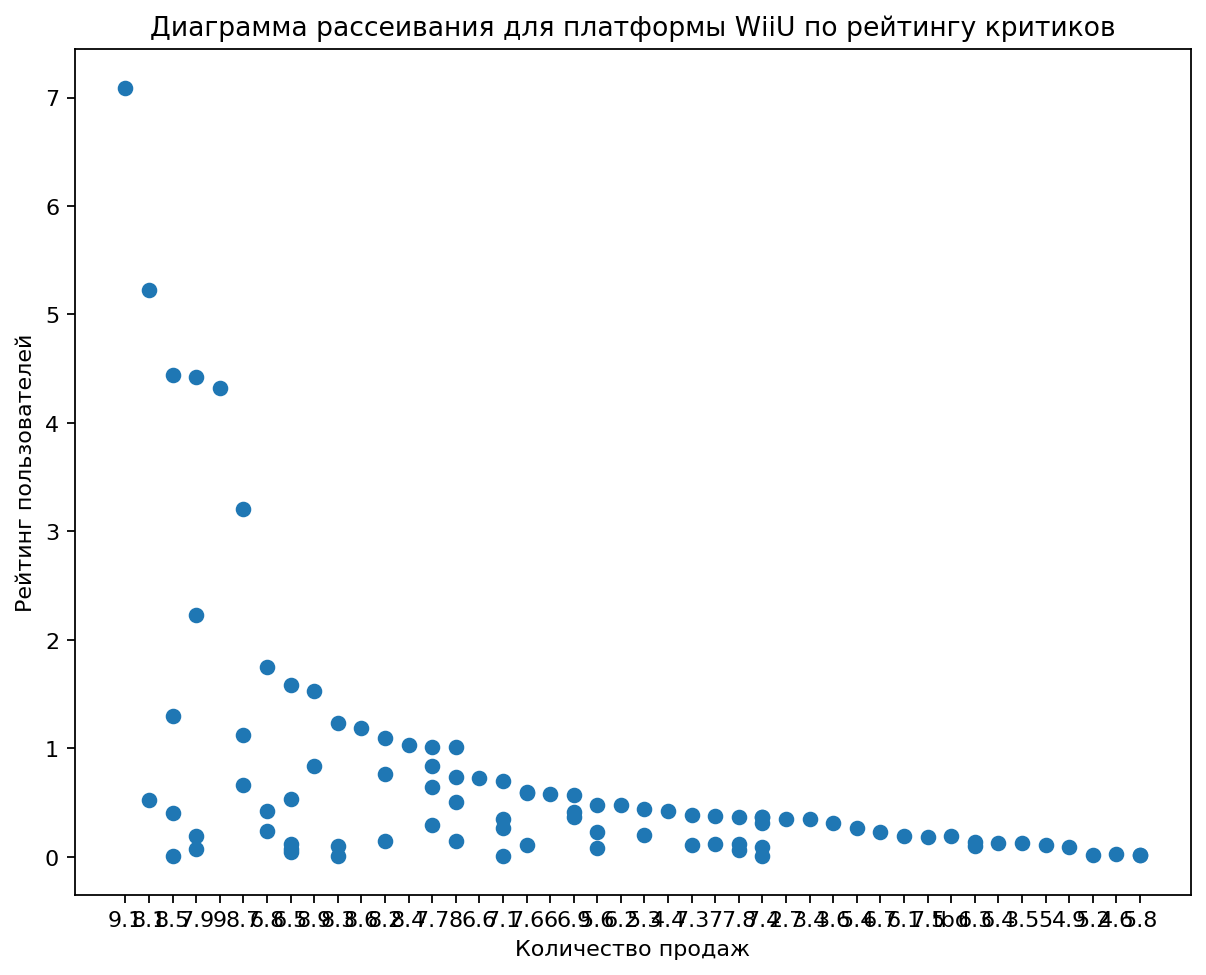

In [56]:
corr_and_scatt(df, "WiiU")

,sum_sales
sum_sales,1.000000
other_sales,0.976711
eu_sales,0.969030
na_sales,0.964017
critic_score,0.221577
year_of_release,-0.230747


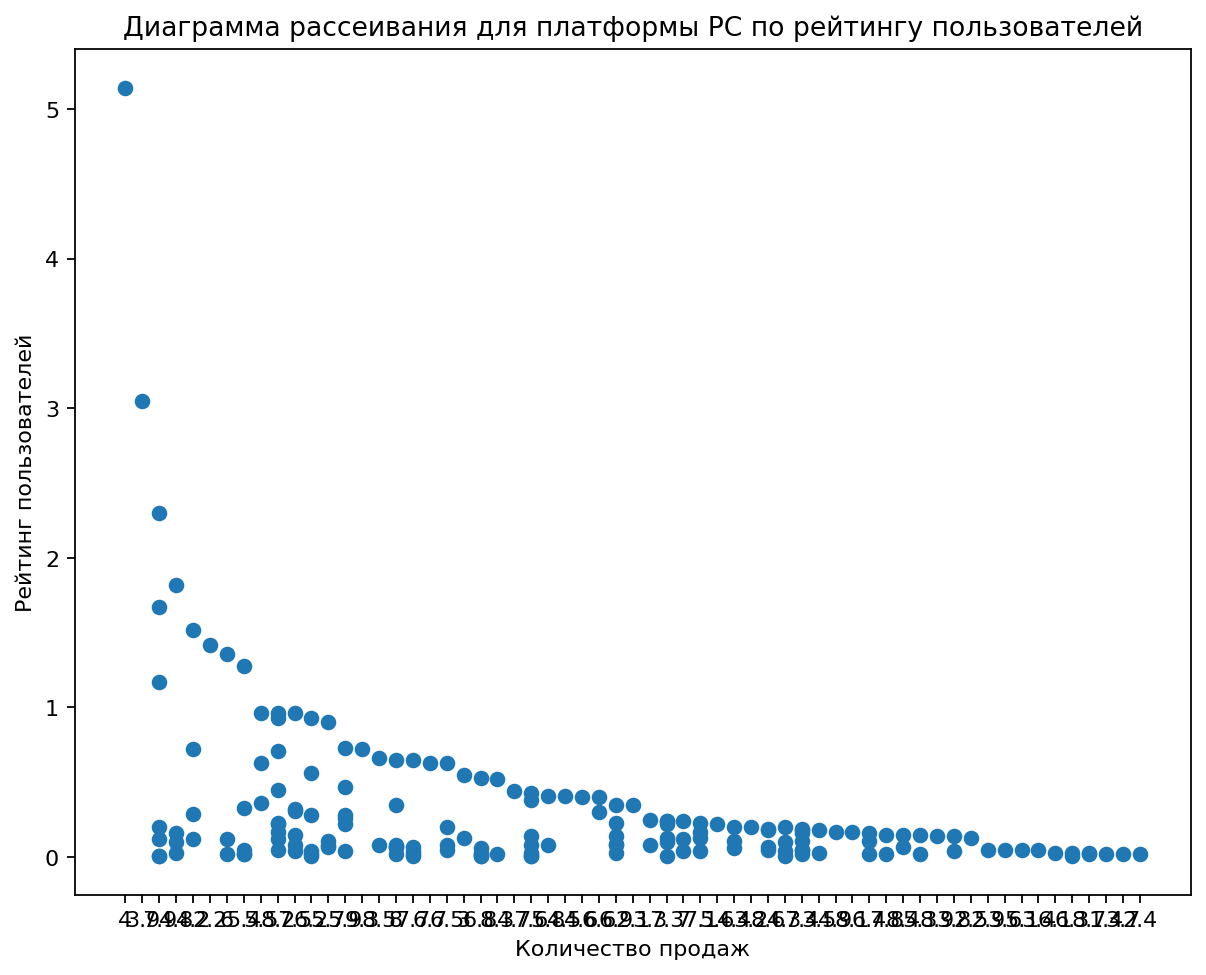

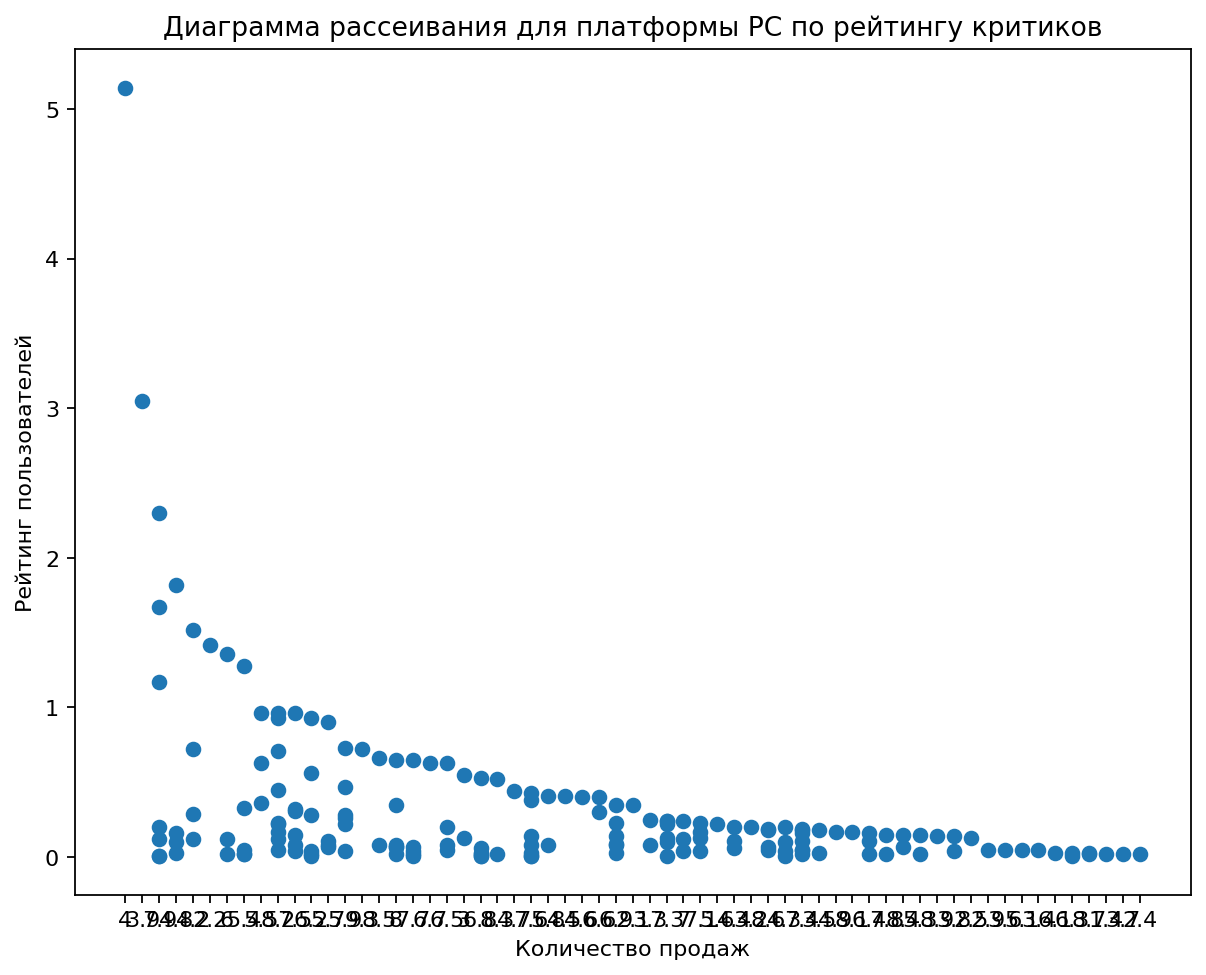

In [57]:
corr_and_scatt(df, "PC")

Только в случае с платформой WiiU мы можем наблюдать слабую корреляцию, во всех остальных случях её как-будто бы и нет.

И наоборот - во всех случаях, кроме WiiU, мы видим более ярко выраженную корреляцию между продажами и оценкой критика.

Скорее всего это связано с тем, что для обычного пользователя сложно оценить игру по какой-либо количественной шкале: пользователю либо нравится игра, либо нет. К примеру, когда игра выходит слишком плохой, случаются "набеги" пользователей и рейтинг игры зануляют. В противном случае, оценка распределяется совершенно случайно и точно не зависит от объема продаж.

### Распределение по жанрам

Посмотрим, какие жанры являются наиболее прибыльными.

In [58]:
display(df.groupby(by='genre')
        .sum()['sum_sales']
        .to_frame()
        .sort_values('sum_sales', ascending=False))

,sum_sales
genre,
Action,131.35
Shooter,129.91
Sports,85.95
Role-Playing,41.22
Platform,28.41
Racing,26.18
Misc,17.73
Fighting,10.45
Simulation,8.44


Самые популярные жанры - action, shooter, sports, role-playing (RPG), platform и racing. Да, разница между продажами экшен-игр и гоночных игр велика, но всё, что идёт ниже - ещё меньше.

### Выводы

В рамках данного этапа работы мы получили следующую информацию:

1. Перспективными платформами являются ПК, XOne, PS4 и WiiU.
2. Актуальный период времени начинается с 2012 года.
3. Высокий рейтинг - не показатель высокого уровня продаж и наоборот.
4. Наиболее популярные жанры - Шутер, Экшен, Спорт, РПГ и платформеры.

## Портреты пользователей

Изучим информацию по предпочтениям пользователей различных регионов. Данное исследование не включает в себя изучение рейтинга критиков и пользователей, поэтому будем пользоваться более полным датафреймом.

### Самые популярные платформы по регионам

In [59]:
display(df_dates_full
        .pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
        .style
        .background_gradient(cmap="YlGnBu")
       )

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.64,87.79,55.31
DS,3.53,3.72,4.59
PC,37.76,0,19.12
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSP,0.42,10.47,0.13
PSV,11.36,21.04,10.98
Wii,11.92,3.39,17.45
WiiU,25.13,13.01,38.1


Наиболее популярными у покупателей из Северной Америки являются игры на следующих платформах: X360, PS4, PS3, XOne а также 3DS. 


В Европейском регионе наблюдается тот же перечень платформ, что и в Северо-Американском регионе.

В японском регионе наиболее популярной платформой для игры является 3DS, а за ней следует линейка Playstation от японской компании Sony. Игры на консолях Xbox в Японии совсем не продаются. Такая же печальная ситуация и у ПК.

Таким образом, если в американском и европейском регионе преобладает противостояние платформ PS3/PS4 и X360/XOne, то в японском пользователи более склонны играть на платформах от Nintendo (3DS и WiiU), либо брать игры на одну из версий Playstation.

### Наиболее популярные жанры

Теперь рассмотрим различия в жанрах.

In [60]:
display(df_dates_full
        .pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
        .style
        .background_gradient(cmap="YlGnBu")
       )

,eu_sales,jp_sales,na_sales
genre,,,
Action,159.34,52.8,177.84
Adventure,9.46,8.24,8.92
Fighting,10.79,9.44,19.79
Misc,26.32,12.86,38.19
Platform,21.41,8.63,25.38
Puzzle,1.4,2.14,1.13
Racing,27.29,2.5,17.22
Role-Playing,48.53,65.44,64
Shooter,113.47,9.23,144.77


По жанрам наблюдаем следующее:

В NA и EU предпочтение даётся динамичным играм в жанрах Action, Shooter, Sport. В Европе на 4-ом и 5-ом местах Role-Play и Racing, а в Америке - Role-Play и Misc. В целом, можно говорить о том, что Американские и Европейские пользователи склонны выбирать примерно одинаковый тип игр. 

В японском регионе с огромным перевесом побеждает жанр Role-play, за ним идёт Action. На 3-5 местах Misc, Simulation, Fighting. Сумма топ-3,4,5 меньше топ-1 или топ-2. То есть смысла продавать игры других жанров, кроме как Role-Play и Action, в Японии не много. 

### Влияние рейтинга ESBR

In [61]:
display(df_dates_full
        .pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
        .style
        .background_gradient(cmap="YlGnBu")
       )

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.7
M,193.96,21.2,231.57
T,52.96,26.02,66.02


Продажа игр с рейтингом M и E в NA и EU даст наибольший результат. При этом продажи buh E10+ и T гораздо меньше, чем ожидалось. Видимо, в данных регионах пользуются популярностью либо игры для всех, либо игры для взрослой аудитории. А всё, что касается игр между - не так популярно.

В Японии же лидирует рейтинг E, а за ним идёт T. Игры с рейтиногм M на третьем месте. А E10+ - на последнем. Это можно объяснить тем, что для японского рынка рейтинг игры имеет не слишком большое значение. 

### Вывод

Пользователи из Америки и Европы схожи в своих предпочтениях:

1. Им по душе игры с быстрым темпом: жанр action, shooter или sports обладают наибольшим спросом.
2. Играть они предпочитают над консолях Xbox или PS4, в противном случае им интересна 3DS
3. Рейтинг игры для них важен - он должен быть либо E (для всех) либо M (для взрослой аудитории). Всё, что между - продаётся хуже.

Пользователи из Японии ведут себя иначе:

1. Им тоже нравятся игры жанра action, но больше они предпочитают игры жанра role-play. Всё остальное продаётся гораздо хуже, и даже игра-хит здесь не поможет собрать столько же, сколько может собрать role-play.
2. Продавать здесь стоит игры для платформ 3DS или PS3/PS4. PSV сходит на нет как консоль, поэтому продавать игры этой серии не имеет смысла. 
3. Рейтинг игры не имеет значения.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем нулевую гипотезу, а также альтернативную гипотезу.

**Нулевая гипотеза:**

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Альтернативная гипотеза:**

Средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [62]:
pc_master_race = df.query('platform == "PC" and user_score != "tbd"')
pc_master_race['user_score'] = pc_master_race['user_score'].astype(float)

XOne_plebs_race = df.query('platform == "XOne" and user_score != "tbd"')
XOne_plebs_race['user_score'] = XOne_plebs_race['user_score'].astype(float)

In [63]:
print("Дисперсия по оценке пользователей ПК равна {:.2f}".format(np.var(pc_master_race['user_score'])))
print("Дисперсия по оценке пользователей Xbox One равна {:.2f}".format(np.var(XOne_plebs_race['user_score'])))

Дисперсия по оценке пользователей ПК равна 2.82
Дисперсия по оценке пользователей Xbox One равна 1.78


Дисперсии сильно различаются - учтем это. Параметр alpha зададим стандартный - 5%.

In [64]:
result = st.ttest_ind(pc_master_race['user_score'], XOne_plebs_race['user_score'], equal_var=False)

print('p-значение:', result.pvalue)

if result.pvalue < 0.05:
    print("Отбрасываем нулевую гипотезу, она несостоятельна")
else:
    print('Нулевая гипотеза не опровергнута')

p-значение: 0.41668656393474524
Нулевая гипотеза не опровергнута


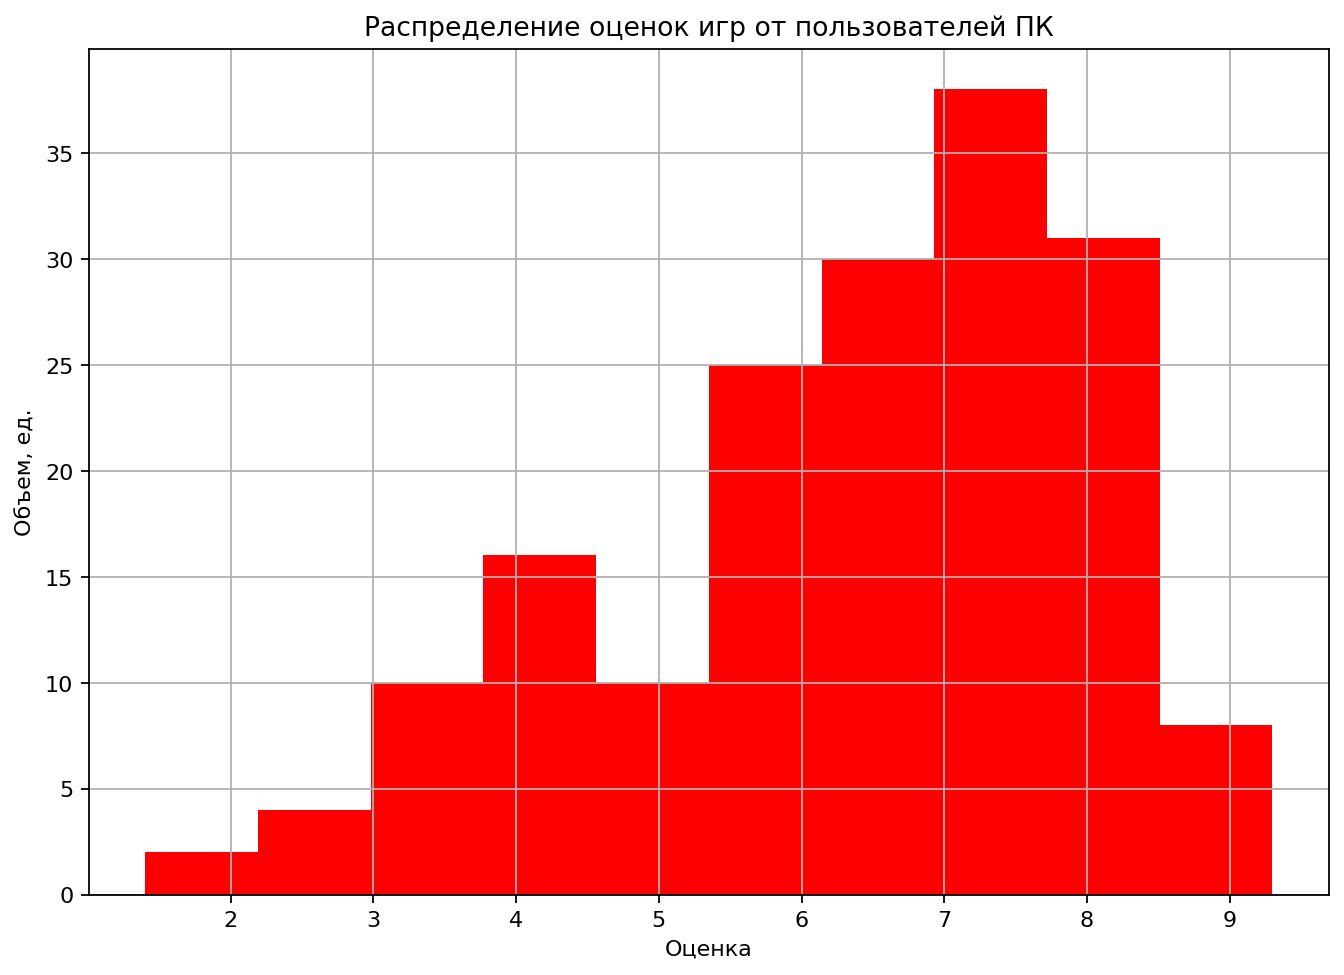

In [65]:
draw_hist(pc_master_race['user_score'], "Распределение оценок игр от пользователей ПК", 'Оценка', color='red')

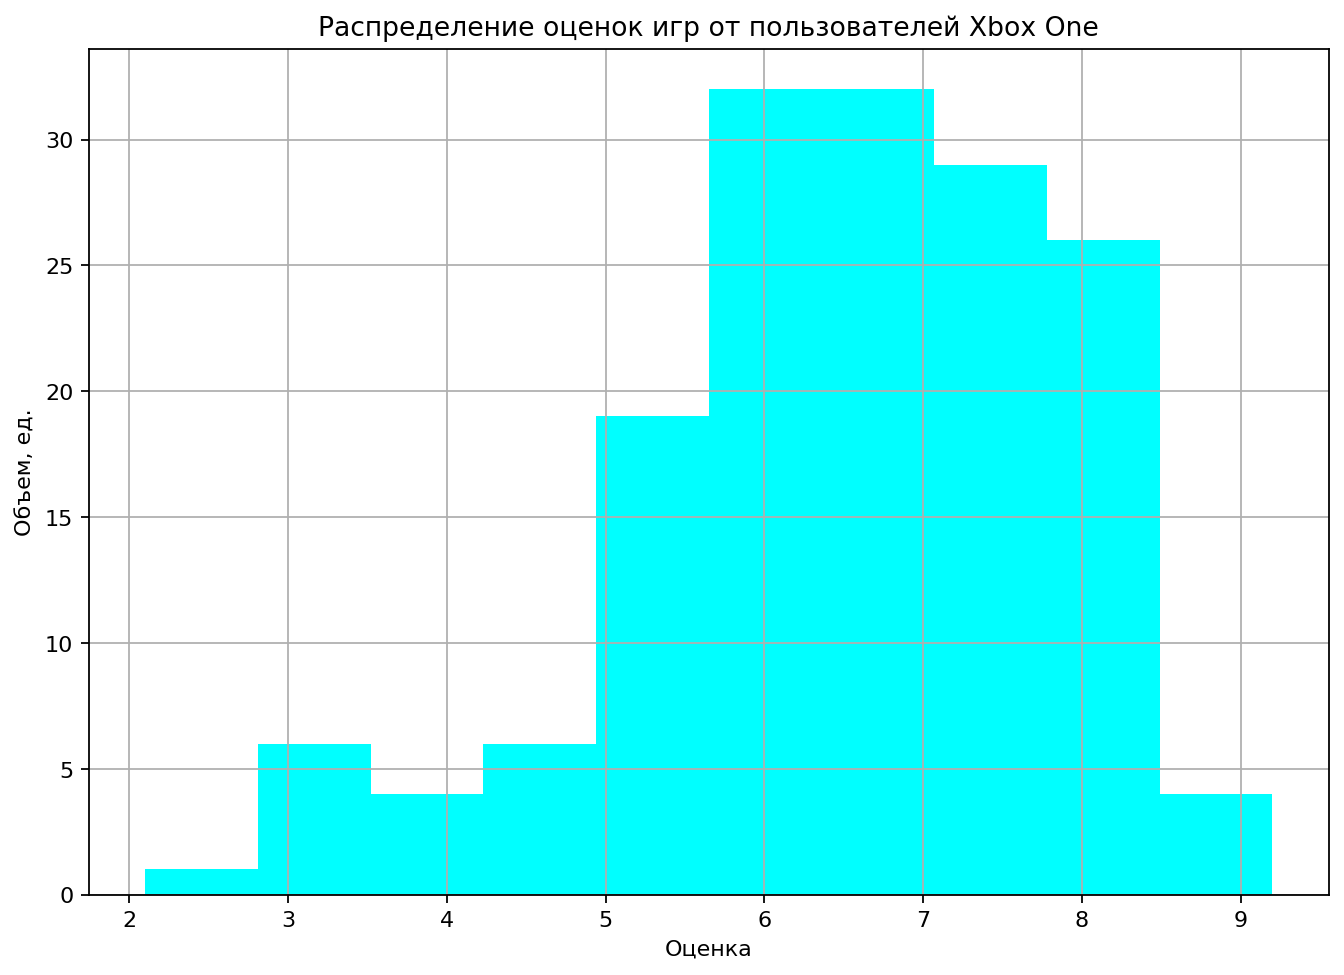

In [66]:
draw_hist(XOne_plebs_race['user_score'], "Распределение оценок игр от пользователей Xbox One", 'Оценка', color='cyan')

Опровергнуть нулевую гипотезу не получилось, поэтому можно утверждать, что средние оценки пользователей ПК и Xbox One примерно одинаковые.

### Средние пользовательские рейтинги жанров Action и Sports разные.

Сформулируем нулевую гипотезу, а также альтернативную гипотезу.

**Нулевая гипотеза:**

Средние пользовательские рейтинги жанров Action и Sports одинаковые.

**Альтернативная гипотеза:**

Средние пользовательские рейтинги жанров Action и Sports различаются.

In [67]:
action = df.query('genre == "Action" and user_score != "tbd"')
sports = df.query('genre == "Sports" and user_score != "tbd"')

action['user_score'] = action['user_score'].astype(float)
sports['user_score'] = sports['user_score'].astype(float)

In [68]:
print("Дисперсия по оценке пользователей жанра Action равна {:.2f}".format(np.var(action['user_score'])))
print("Дисперсия по оценке пользователей жанра Sports равна {:.2f}".format(np.var(sports['user_score'])))

Дисперсия по оценке пользователей жанра Action равна 1.68
Дисперсия по оценке пользователей жанра Sports равна 2.17


Дисперсии сильно различаются - учтем это. Параметр alpha зададим стандартный - 5%.

In [69]:
result = st.ttest_ind(action['user_score'], sports['user_score'], equal_var=False)

print('p-значение:', result.pvalue)

if result.pvalue < 0.05:
    print("Отбрасываем нулевую гипотезу, она несостоятельна")
else:
    print('Нулевая гипотеза не опровергнута')

p-значение: 2.912224632137357e-09
Отбрасываем нулевую гипотезу, она несостоятельна


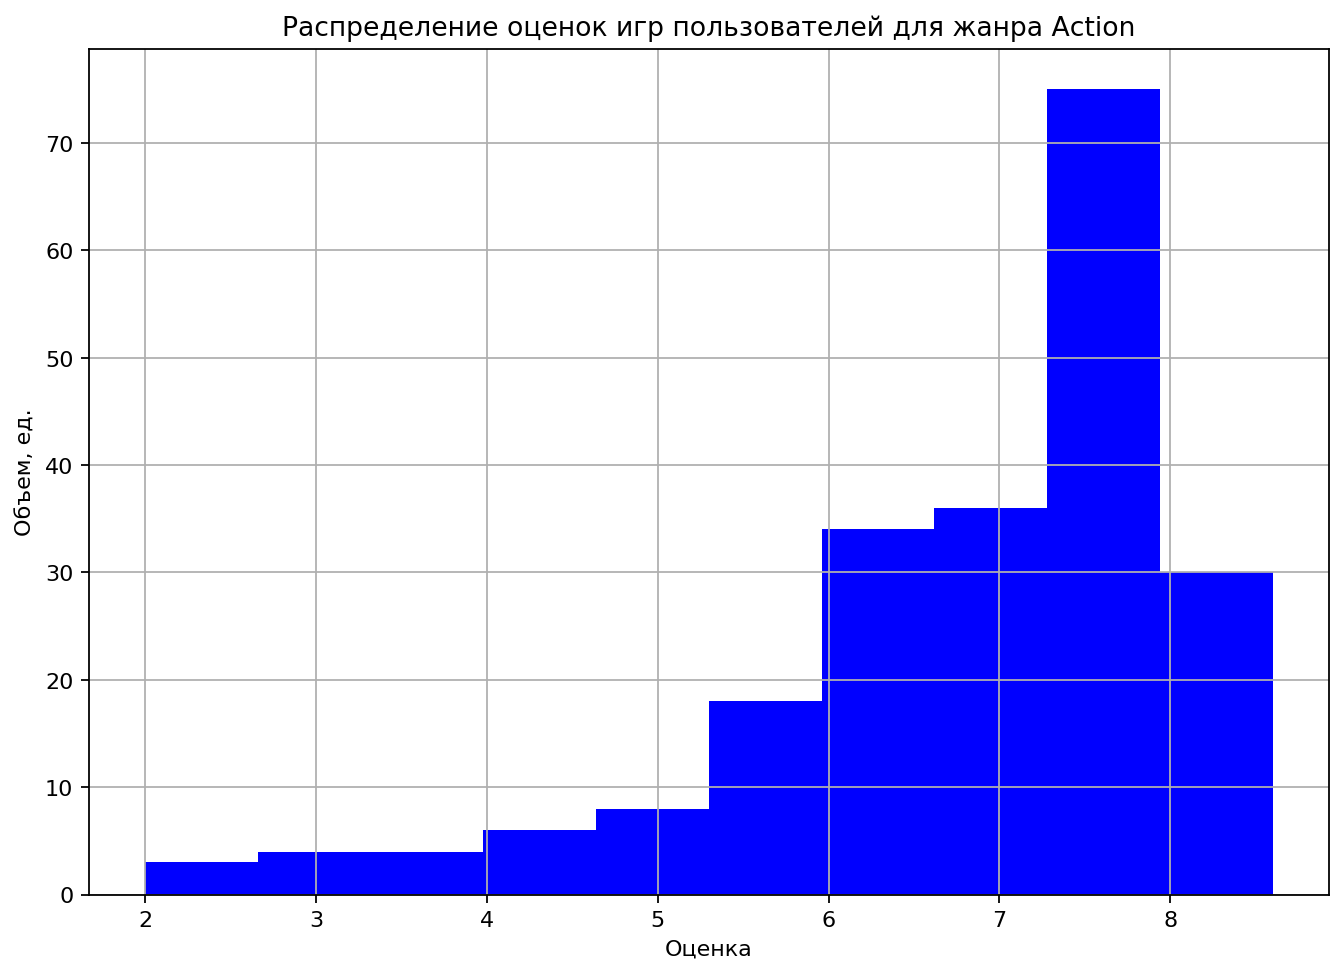

In [70]:
draw_hist(action['user_score'], "Распределение оценок игр пользователей для жанра Action", 'Оценка', color='blue')

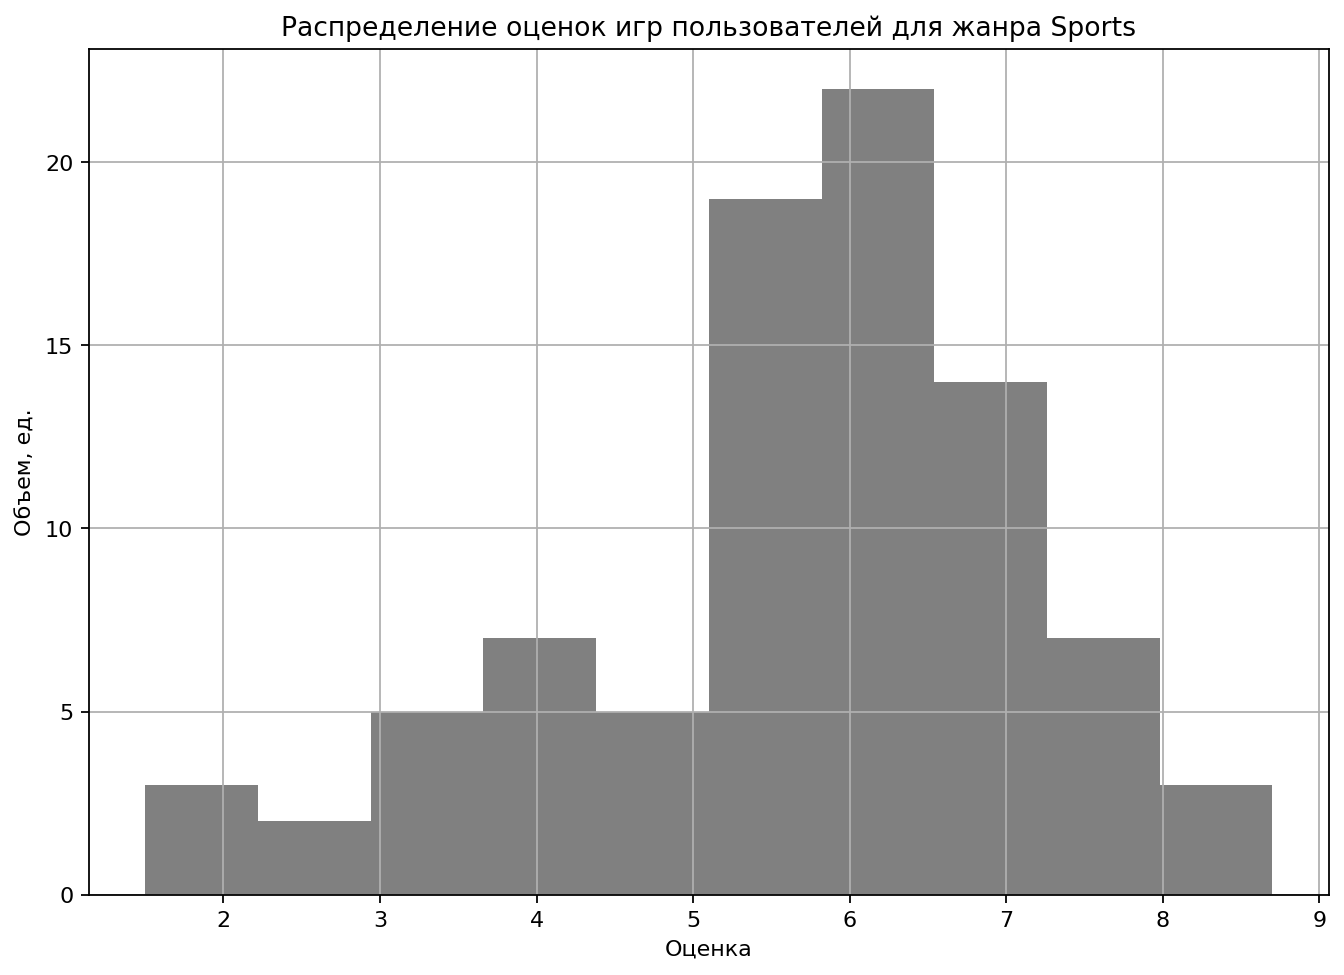

In [71]:
draw_hist(sports['user_score'], "Распределение оценок игр пользователей для жанра Sports", 'Оценка', color='grey')

Так получилось, что нулевая гипотеза оказалась несостоятельна. Так как альтернативная гипотеза является обратной к нулевой - её нам не получится опровергнуть. 

### Вывод

Как итог - обе предложенные гипотезы были не опровергнуты, а это значит, что они близки к истине.

Дисперия в обоих случаях различалась на большое значение, поэтому мы пользовались аттрибутом `equal_var=False`. Альфу задавали равной 0.05 или 5%.

##  Вывод по работе

Выпишем поставленную задачу и попытаемся на неё ответить:

**Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.**

Для того, чтобы определить успешность игры, мы проделали следующее: 

В Шаге № 3 мы выяснили, что актуальными и перспективными платформами для выпуска игр являются платформы PS4 и XOne, а также WiiU. Также мы отметили платформу 3DS и PC, но первая находится на завершающем этапе своего жизненного цикла, а вторая обычно продаётся хуже. 

В Шаге № 4 мы указали на то, какие предпочтения есть у пользователей различных регионов. Мы отметили, что европейский регион схож с американским в части жанровых предпочтений, а японский - совсем другой. Но у этих регионов есть общий популярный жанр - Action. Также мы можем отметить, что с учетом японского рынка имеет смысл вкладывать средства в продвижение игр на PS4 - эта перспективная платформа наиболее популярна. XOne имеет смысл продвигать только для европейского и американского регионов. Для игры желательно иметь рейтинг E или M, тогда у неё будет больше шансов хорошо продаваться во всех основных регионах.

Таким образом, самый верный способ - вложиться в маркетинг игры на платформе PS4 с жанром Action. 

Отметим дополнительно, что в Шаге № 5 мы проверили и подтвердили 2 гипотезы: пользователи XOne и PC ставят примерно одинаковые оценки, а для жанров Sports и Action пользователи обычно ставят разные.


В ходе работы мы обнаружили следующие инсайды:

1. Актуальные платформы на конец 2016 года - PS4, XOne, WiiU и PC.
2. Продажи на PC в общем случае меньше, чем для какой-либо популярной консоли от Microsoft, Sony или Nintendo. И даже в последние года жизненного цикла популярных платформ продажи игр для консолей превышали продажи игр для ПК. Поэтому на рынок игр на ПК не стоит ориентироваться.
3. С начала 10-ых прослеживается тренд на падение продаж для всех платформ, а также на падение количество выпускаемых игр. Возможно, всё дело в том, что мобильные игры становятся предпочтительнее компьютерных. Ведь телефон есть у каждого.
4. На объем
5. Американский и европейский регионы схожи по предпочтениям, а Японский регион - совсем другой.
